<a href="https://colab.research.google.com/github/PedroT111/Regional-Greenhouse-Gas-Emission-Forecasting/blob/main/TP_FAO_Ciencia_de_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar y descomprimir el dataset, instalar e importar las librerías a utilizar

In [ ]:
!pip install gdown --quiet
!pip install plotly pycountry
!pip install geopandas
!pip install ipywidgets statsmodels --quiet
!pip install country_converter
!pip install prophet
!pip install prophet --no-binary :all:


In [ ]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import numpy as np
import plotly.express as px
import pycountry
import geopandas as gpd
import plotly.graph_objects as go
import statsmodels.api as sm
import itertools
import time
import warnings
import logging
import sys

from statsmodels.tsa.statespace.sarimax import SARIMAX
from ipywidgets import interact, widgets
from IPython.display import display, HTML
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

In [ ]:
def download_and_extract_zip(drive_id: str, output_dir: str, zip_name: str):
    """
    Descarga y descomprime un archivo ZIP desde Google Drive.

    Args:
        drive_id (str): ID del archivo en Google Drive.
        output_dir (str): Carpeta donde se guardará y descomprimirá el archivo.
        zip_name (str): Nombre que tendrá el archivo ZIP descargado (con .zip).

    Returns:
        bool: True si todo fue exitoso, False si hubo algún error.
    """
    try:
        os.makedirs(output_dir, exist_ok=True)
        zip_path = os.path.join(output_dir, zip_name)

        # Download
        gdown.download(id=drive_id, output=zip_path, quiet=False)

        # Extract
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        # Delete zip
        os.remove(zip_path)

        print(f"Download and extraction completed at: {output_dir}")
        return True

    except Exception as e:
        print(f"Error: {e}")
        return False

In [ ]:
os.makedirs("data/raw/excercise", exist_ok=True)
download_and_extract_zip(
    drive_id="1hDcwMcaajRkoaO8trMqqc8DWObGkZl8v",
    output_dir="data/raw/excercise",
    zip_name="Emisiones_Totales_S_Todos_los_Datos_(Normalizado).zip"
)

Downloading...
From: https://drive.google.com/uc?id=1hDcwMcaajRkoaO8trMqqc8DWObGkZl8v
To: /content/data/raw/excercise/Emisiones_Totales_S_Todos_los_Datos_(Normalizado).zip
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


Download and extraction completed at: data/raw/excercise


True

# 1. Revisión del Dataset

## Estructura del archivo, tipos de variables, dimensiones y unidades.

In [ ]:
df = pd.read_csv('/content/data/raw/excercise/Emisiones_Totales_S_Todos_los_Datos_(Normalizado).csv')

In [ ]:
# Dimensión del df (filas, columnas)
print("df (rows, cols):", df.shape)

df (rows, cols): (2397460, 15)


In [ ]:
# Información general de las columnas y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397460 entries, 0 to 2397459
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Código del área        int64  
 1   Código del área (M49)  object 
 2   Área                   object 
 3   Código del producto    int64  
 4   Producto               object 
 5   Código del elemento    int64  
 6   Elemento               object 
 7   Código del año         int64  
 8   Año                    int64  
 9   Código fuente          int64  
 10  Fuente                 object 
 11  Unidad                 object 
 12  Valor                  float64
 13  Símbolo                object 
 14  Nota                   float64
dtypes: float64(2), int64(6), object(7)
memory usage: 274.4+ MB


In [ ]:
df.head()

,Código del área,Código del área (M49),Área,Código del producto,Producto,Código del elemento,Elemento,Código del año,Año,Código fuente,Fuente,Unidad,Valor,Símbolo,Nota
0,2,'004,Afganistán,5064,Residuos agrícolas,7234,Emisiones directas (N2O),1961,1961,3050,FAO TIER 1,kilotones,0.8762,E,NaN
1,2,'004,Afganistán,5064,Residuos agrícolas,7234,Emisiones directas (N2O),1962,1962,3050,FAO TIER 1,kilotones,0.8829,E,NaN
2,2,'004,Afganistán,5064,Residuos agrícolas,7234,Emisiones directas (N2O),1963,1963,3050,FAO TIER 1,kilotones,0.8236,E,NaN
3,2,'004,Afganistán,5064,Residuos agrícolas,7234,Emisiones directas (N2O),1964,1964,3050,FAO TIER 1,kilotones,0.8882,E,NaN
4,2,'004,Afganistán,5064,Residuos agrícolas,7234,Emisiones directas (N2O),1965,1965,3050,FAO TIER 1,kilotones,0.8978,E,NaN


## 2. Limpieza de datos

In [ ]:
# Valores faltantes
df.isnull().sum()

,0
Código del área,0
Código del área (M49),0
Área,0
Código del producto,0
Producto,0
Código del elemento,0
Elemento,0
Código del año,0
Año,0
Código fuente,0


In [ ]:
# Duplicated rows
df.duplicated().sum()

np.int64(0)

Agregamos dos columnas con los datos en otras unidades para que sean mas legibles los gráficos

In [ ]:
df['Valor_Mt'] = df['Valor'] / 1e3           # megatoneladas
df['Valor_Gt'] = df['Valor'] / 1e6           # gigatoneladas

El dataset original incluye  columnas relacionadas con códigos numéricos, metadatos y etiquetas auxiliares que no aportan valor directo al análisis de emisiones. Por lo tanto, consideramos razonable eliminarlas.
### Columnas eliminadas:
- **`Nota`**: la columna está vacía en el 100% de los registros
- **`Código del área` / `Código del área (M49)`**: estos códigos geográficos están duplicados con la columna `Área`, que ya contiene el nombre del país o región.
- **`Código del producto` / `Código del elemento` / `Código del año`**: estos códigos numéricos son equivalentes a las columnas `Producto`, `Elemento` y `Año`, que contienen información descriptiva más útil.
- **`Código fuente`**: indica el código numérico de la Fuente, lo cual es redundante al mantener la columna Fuente.


In [ ]:
df_cleaned = df.drop(columns=['Nota','Código del área', 'Código del área (M49)', 'Código del elemento', 'Código del año', 'Código fuente']).copy()

In [ ]:
print(df_cleaned.columns)

Index(['Área', 'Código del producto', 'Producto', 'Elemento', 'Año', 'Fuente',
       'Unidad', 'Valor', 'Símbolo', 'Valor_Mt', 'Valor_Gt'],
      dtype='object')


## Cobertura temporal



### 1.  Rango temporal

In [ ]:
# Mostrar rango temporal
anio_min = df['Año'].min()
anio_max = df['Año'].max()
print(f'Rango temporal de los datos: {anio_min} - {anio_max}')

Rango temporal de los datos: 1961 - 2050




### 2. Cantidad de registros por año

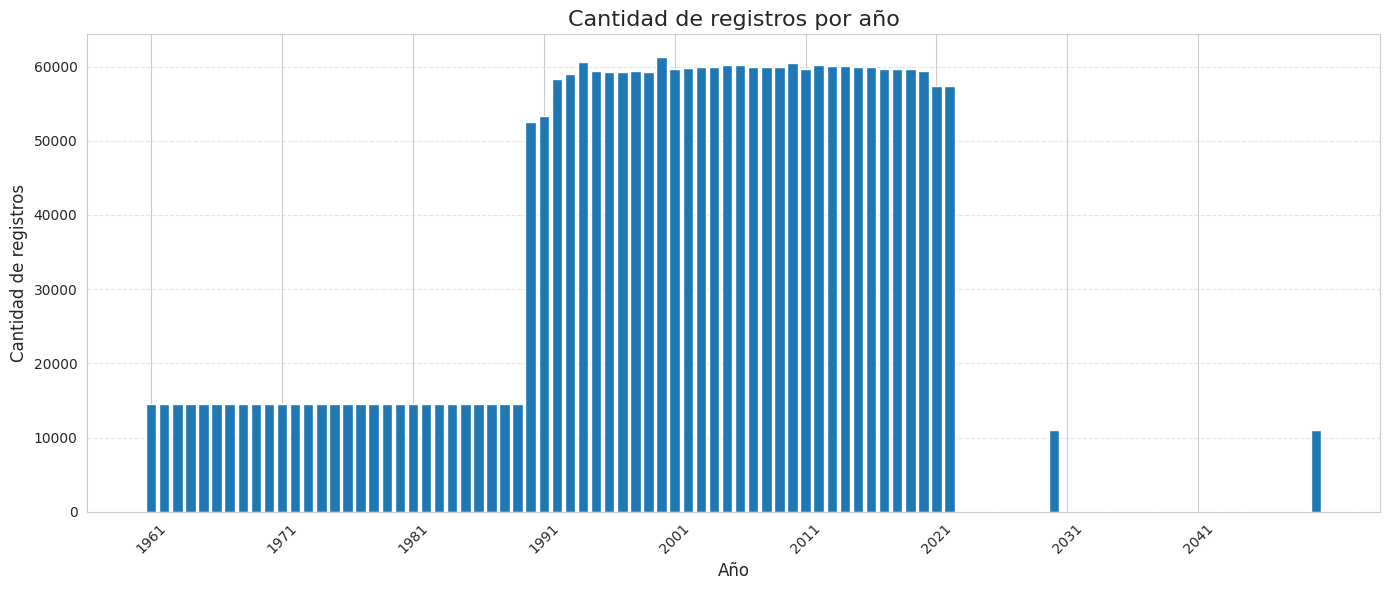

In [ ]:
records_year = df_cleaned['Año'].value_counts().sort_index()
ticks = range(records_year.index.min(), records_year.index.max() + 1, 10)
plt.figure(figsize=(14, 6))
plt.bar(records_year.index, records_year.values)
plt.title('Cantidad de registros por año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de registros', fontsize=12)
plt.xticks(ticks,rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Como se puede observar en el gráfico, existe una gran cantidad de registros a partir del año 1990.
A partir de los años 90, muchos países comenzaron a reportar datos más detallados y sistemáticos debido a compromisos internacionales (por ejemplo, la Convención Marco de las Naciones Unidas sobre el Cambio Climático, firmada en 1992).
Antes de 1990, la información era muy escasa y parcial

No significa que aumentaron las emisiones, sino que aumentó la cobertura de datos:

* Se empieza a reportar por más países.

* Se suman más categorías de emisiones (por sector: energía, agricultura, residuos, etc.).

* Se incorporan más variables por cada año.

### 3. Cobertura Geográfica

Para analizar la cobertura geográfica del dataset, nos pareció conveniente separar los datos de acuerdo a si se trata de datos de paises o de una región


In [ ]:
regiones = [
    'Mundo', 'Países Anexo I', 'Países No-Anexo I', 'Unión Europea (27)', 'Unión Europea (28)',
    'África', 'Américas', 'Europa', 'Asia', 'Oceanía',
    'África occidental', 'África central', 'África oriental', 'África meridional', 'África septentrional',
    'América central', 'América del Sur', 'América septentrional',
    'Europa occidental', 'Europa oriental', 'Europa septentrional', 'Europa meridional',
    'Asia central', 'Asia oriental', 'Asia occidental', 'Asia sudoriental', 'Asia meridional',
    'Australia y Nueva Zelandia', 'El Caribe', 'Melanesia', 'Polinesia', 'Micronesia',
    'OECD', 'URSS', 'Checoslovaq', 'Yugoslav RFS',
    'Los países menos desarrollados', 'Países sin litoral en vías de desarrollo',
    'Países de bajos ingresos y con déficit de alim.', 'Pequeñas islas en vías de Desarrollo',
    'Import netos alim en Des', 'Territorio de las Islas del Pacífico', 'China, Continental'
    ]

In [ ]:
df_regiones = df_cleaned[df_cleaned['Área'].isin(regiones)].copy()

In [ ]:
df_regiones['Área'].unique()

array(['Checoslovaq', 'China, Continental',
       'Territorio de las Islas del Pacífico', 'URSS', 'Yugoslav RFS',
       'Mundo', 'África', 'África oriental', 'África central',
       'África septentrional', 'África meridional', 'África occidental',
       'Américas', 'América septentrional', 'América central',
       'El Caribe', 'América del Sur', 'Asia', 'Asia central',
       'Asia oriental', 'Asia meridional', 'Asia sudoriental',
       'Asia occidental', 'Europa', 'Europa oriental',
       'Europa septentrional', 'Europa meridional', 'Europa occidental',
       'Oceanía', 'Australia y Nueva Zelandia', 'Melanesia', 'Micronesia',
       'Polinesia', 'Unión Europea (27)',
       'Los países menos desarrollados',
       'Países sin litoral en vías de desarrollo',
       'Pequeñas islas en vías de Desarrollo',
       'Países de bajos ingresos y con déficit de alim.',
       'Import netos alim en Des', 'Países Anexo I', 'Países No-Anexo I',
       'OECD'], dtype=object)

In [ ]:
df_countries = df_cleaned[~df_cleaned['Área'].isin(regiones)].copy()

In [ ]:
print("Cantidad de países:", df_countries['Área'].nunique())

Cantidad de países: 238


In [ ]:
countries = df_countries['Área'].unique()

#### Diccionario para corregir los nombre de los paises

In [ ]:
fixes = {
    'Anguila': 'Anguilla',
    'Bahrein': 'Bahrain',
    'Bermudas': 'Bermuda',
    'Bhután': 'Bhutan',
    'Bélgica': 'Belgium',
    'Cabo Verde': 'Cape Verde',
    'Chequia': 'Czechia',
    'Chipre': 'Cyprus',
    'Comoras': 'Comoros',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Gambia': 'The Gambia',
    'Granada': 'Grenada',
    'Guadalupe': 'Guadeloupe',
    'Guayana Francesa': 'French Guiana',
    'Isla Norfolk': 'Norfolk Island',
    'Isla de Man': 'Isle of Man',
    'Islas Anglonormandas': 'Channel Islands',
    'Islas Caimán': 'Cayman Islands',
    'Islas Cook': 'Cook Islands',
    'Islas Feroe': 'Faroe Islands',
    'Islas Marianas del Norte': 'Northern Mariana Islands',
    'Islas Marshall': 'Marshall Islands',
    'Islas Salomón': 'Solomon Islands',
    'Islas Svalbard y Jan Mayen': 'Svalbard and Jan Mayen',
    'Islas Turcas y Caicos': 'Turks and Caicos Islands',
    'Islas Vírgenes Británicas': 'British Virgin Islands',
    'Islas Vírgenes de los Estados Unidos': 'United States Virgin Islands',
    'Islas Wallis y Futuna': 'Wallis and Futuna',
    'Martinica': 'Martinique',
    'Mónaco': 'Monaco',
    'Nueva Caledonia': 'New Caledonia',
    'Palestina': 'Palestine',
    'Países Bajos (Reino de los)': 'Netherlands',
    'Polinesia Francesa': 'French Polynesia',
    'República Democrática del Congo': 'Democratic Republic of the Congo',
    'República Democrática Popular Lao': "Lao People's Democratic Republic",
    'República Popular Democrática de Corea': "Democratic People's Republic of Korea",
    'Reunión': 'Réunion',
    'Saint Kitts y Nevis': 'Saint Kitts and Nevis',
    'Samoa Americana': 'American Samoa',
    'San Pedro y Miquelón': 'Saint Pierre and Miquelon',
    'Santa Elena, Ascensión y Tristán de Acuña': 'Saint Helena, Ascension and Tristan da Cunha',
    'Santa Sede': 'Holy See',
    'Sierra Leona': 'Sierra Leone',
    'Sudán (ex)': 'Sudan',
    'Sáhara Occidental': 'Western Sahara',
    'Timor-Leste': 'Timor-Leste',
    'Trinidad y Tabago': 'Trinidad and Tobago',
    'Yugoslav RFS': 'Yugoslavia',
    "Afganistán": "Afghanistan",
    "Albania": "Albania",
    "Alemania": "Germany",
    "Angola": "Angola",
    "Antigua y Barbuda": "Antigua and Barbuda",
    "Arabia Saudita": "Saudi Arabia",
    "Argelia": "Algeria",
    "Argentina": "Argentina",
    "Armenia": "Armenia",
    "Austria": "Austria",
    "Azerbaiyán": "Azerbaijan",
    "Bangladés": "Bangladesh",
    "Baréin": "Bahrain",
    "Belice": "Belize",
    "Belarús": "Belarus",
    "Bolivia (Estado Plurinacional de)": "Bolivia",
    "Bosnia y Herzegovina": "Bosnia and Herzegovina",
    "Botsuana": "Botswana",
    "Brasil": "Brazil",
    "Brunéi Darussalam": "Brunei",
    "Bulgaria": "Bulgaria",
    "Burkina Faso": "Burkina Faso",
    "Camboya": "Cambodia",
    "Camerún": "Cameroon",
    "Canadá": "Canada",
    "Chad": "Chad",
    "Chile": "Chile",
    "China": "China",
    "Colombia": "Colombia",
    "Corea, República de": "South Korea",
    "Costa de Marfil": "Ivory Coast",
    "Croacia": "Croatia",
    "Cuba": "Cuba",
    "Dinamarca": "Denmark",
    "Ecuador": "Ecuador",
    "Egipto": "Egypt",
    "El Salvador": "El Salvador",
    "Eritrea": "Eritrea",
    "Eslovaquia": "Slovakia",
    "Eslovenia": "Slovenia",
    "España": "Spain",
    "Estados Unidos de América": "United States of America",
    "Estonia": "Estonia",
    "Esuatini": "Eswatini",
    "Etiopía": "Ethiopia",
    "Filipinas": "Philippines",
    "Finlandia": "Finland",
    "Francia": "France",
    "Gabón": "Gabon",
    "Georgia": "Georgia",
    "Ghana": "Ghana",
    "Grecia": "Greece",
    "Groenlandia": "Greenland",
    "Guatemala": "Guatemala",
    "Guinea": "Guinea",
    "Guinea-Bissau": "Guinea-Bissau",
    "Guinea Ecuatorial": "Equatorial Guinea",
    "Haití": "Haiti",
    "Honduras": "Honduras",
    "Hungría": "Hungary",
    "India": "India",
    "Indonesia": "Indonesia",
    "Irak": "Iraq",
    "Irán (República Islámica del)": "Iran",
    "Irlanda": "Ireland",
    "Islandia": "Iceland",
    "Israel": "Israel",
    "Italia": "Italy",
    "Japón": "Japan",
    "Jordania": "Jordan",
    "Kazajstán": "Kazakhstan",
    "Kenia": "Kenya",
    "Kirguistán": "Kyrgyzstan",
    "Líbano": "Lebanon",
    "Liberia": "Liberia",
    "Libia": "Libya",
    "Lesoto": "Lesotho",
    "Letonia": "Latvia",
    "Lituania": "Lithuania",
    "Luxemburgo": "Luxembourg",
    "Madagascar": "Madagascar",
    "Malasia": "Malaysia",
    "Malawi": "Malawi",
    "Maldivas": "Maldives",
    "Malí": "Mali",
    "Malta": "Malta",
    "Marruecos": "Morocco",
    "Mauricio": "Mauritius",
    "Mauritania": "Mauritania",
    "México": "Mexico",
    "Micronesia (Estados Federados de)": "Federated States of Micronesia",
    "Mongolia": "Mongolia",
    "Montenegro": "Montenegro",
    "Mozambique": "Mozambique",
    "Namibia": "Namibia",
    "Nepal": "Nepal",
    "Nicaragua": "Nicaragua",
    "Níger": "Niger",
    "Nigeria": "Nigeria",
    "Noruega": "Norway",
    "Nueva Zelandia": "New Zealand",
    "Omán": "Oman",
    "Pakistán": "Pakistan",
    "Panamá": "Panama",
    "Papua Nueva Guinea": "Papua New Guinea",
    "Paraguay": "Paraguay",
    "Perú": "Peru",
    "Polonia": "Poland",
    "Portugal": "Portugal",
    "Qatar": "Qatar",
    "Reino Unido de Gran Bretaña e Irlanda del Norte": "United Kingdom",
    "República Árabe Siria": "Syria",
    "República Centroafricana": "Central African Republic",
    "República Checa": "Czech Republic",
    "República de Corea": "South Korea",
    "República de Moldova": "Moldova",
    "República Dominicana": "Dominican Republic",
    'República Unida de Tanzanía': 'Tanzania',
    "RDP Lao": "Laos",
    "Rumanía": "Romania",
    "Federación de Rusia": "Russian Federation",
    "San Cristóbal y Nieves": "Saint Kitts and Nevis",
    "Santa Lucía": "Saint Lucia",
    "San Vicente y las Granadinas": "Saint Vincent and the Grenadines",
    "Santo Tomé y Príncipe": "Sao Tome and Principe",
    "Samoa": "Samoa",
    "Senegal": "Senegal",
    "Serbia": "Serbia",
    "Seychelles": "Seychelles",
    "Singapur": "Singapore",
    "Sri Lanka": "Sri Lanka",
    "Sudáfrica": "South Africa",
    "Sudán": "Sudan",
    "Sudán del Sur": "South Sudan",
    "Suecia": "Sweden",
    "Suiza": "Switzerland",
    "Suriname": "Suriname",
    "Tailandia": "Thailand",
    "Tanzania, República Unida de": "Tanzania",
    "Tayikistán": "Tajikistan",
    "Timor-Leste": "East Timor",
    "Tonga": "Tonga",
    "Trinidad y Tobago": "Trinidad and Tobago",
    "Túnez": "Tunisia",
    "Turkmenistán": "Turkmenistan",
    "Turquía": "Türkiye",
    "Ucrania": "Ukraine",
    "Uruguay": "Uruguay",
    "Uzbekistán": "Uzbekistan",
    "Venezuela (República Bolivariana de)": "Venezuela",
    "Viet Nam": "Vietnam",
    "Yemen": "Yemen",
    "Zambia": "Zambia",
    "Zimbabue": "Zimbabwe",
    "Estado de Palestina": "Palestine",
    "Macedonia del Norte": "North Macedonia",
    'República del Congo': 'Congo',
}


In [ ]:
fixed_countries = [fixes.get(p, p) for p in countries]

# Obtener código ISO-3 para cada país
def get_iso3(name):
    '''
    Esta función busca cada nombre en la base de datos oficial de pycountry:

    Si encuentra el país  devuelve el código ISO-3 (ARG para Argentina, BRA para Brasil, etc.).

    Si falla (nombre raro, no existe)  devuelve None
    '''
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None

iso_codes = [get_iso3(p) for p in fixed_countries] #  obtiene una lista de códigos ISO-3 o None si falló
df_map = pd.DataFrame({'country': countries, 'iso_alpha': iso_codes}) # Crea un nuevo DataFrame con dos columnas:'country' → nombre original (sin corrección), 'iso_alpha' → código ISO-3 resultante (de la versión corregida)
df_map = df_map.dropna()  # Elimina las filas donde iso_alpha es None.

# Añadir una columna "coverage" para indicar cobertura
df_map['coverage'] = 1  # 1 = incluido en el dataset

# Crear mapa interactivo con Plotly
fig = px.choropleth(
    df_map,
    locations='iso_alpha',
    color='coverage',
    hover_name='country',
    color_continuous_scale=[[0, 'lightgrey'], [1, 'green']],
    title='Cobertura geográfica del dataset FAOSTAT'
)

fig.update_geos(bgcolor='lightblue',showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")
fig.update_layout(coloraxis_showscale=False, margin={"r":10,"t":40,"l":10,"b":10})
fig.show()

## Registros por País por Año

In [ ]:
#Agrupar por país y año
df_anual = df_countries.groupby(['Área', 'Año']).size().reset_index(name='records')

#Aplicar equivalencias de nombres
df_anual['country'] = df_anual['Área'].replace(fixes)
df_anual['iso_alpha'] = df_anual['country'].apply(get_iso3)
df_anual = df_anual[df_anual['iso_alpha'].notnull()]

#Crear mapa animado
fig = px.choropleth(
    df_anual,
    locations='iso_alpha',
    color='records',
    hover_name='country',
    color_continuous_scale='Viridis',
    animation_frame='Año',
    title='Evolución anual de registros por país'
)

fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


##Expansión en la cobertura de países a partir de 1990
A partir del año 1990 se observa un incremento significativo en la cantidad de países con datos disponibles. Este cambio no necesariamente implica un aumento real en las emisiones, sino una mejora en la cobertura geográfica del dataset.

En total, se incorporan 52 nuevos países/regiones después de 1990, lo que puede influir en los análisis agregados si no se controla adecuadamente.

Para evitar conclusiones erróneas, este notebook incluye filtros y comparaciones que tienen en cuenta este cambio estructural en la base de datos.

In [ ]:
# Conjuntos de países por período
areas_before_1990 = set(df_cleaned[df_cleaned['Año'] < 1990]['Área'].unique())
areas_after_1990 = set(df_cleaned[df_cleaned['Año'] > 1990]['Área'].unique())

# Nuevas áreas que no estaban antes
new_areas = sorted(list(areas_after_1990 - areas_before_1990))

print(f"Nuevas áreas registradas después de 1990: {len(new_areas)}")
print(new_areas)

Nuevas áreas registradas después de 1990: 52
['Armenia', 'Asia central', 'Azerbaiyán', 'Belarús', 'Bosnia y Herzegovina', 'Bélgica', 'Chequia', 'Croacia', 'Eritrea', 'Eslovaquia', 'Eslovenia', 'Estonia', 'Etiopía', 'Federación de Rusia', 'Georgia', 'Gibraltar', 'Guam', 'Isla Norfolk', 'Isla de Man', 'Islas Anglonormandas', 'Islas Caimán', 'Islas Malvinas (Falkland Islands)', 'Islas Marianas del Norte', 'Islas Marshall', 'Islas Svalbard y Jan Mayen', 'Islas Vírgenes de los Estados Unidos', 'Islas Wallis y Futuna', 'Kazajstán', 'Kirguistán', 'Letonia', 'Lituania', 'Luxemburgo', 'Macedonia del Norte', 'Mayotte', 'Micronesia (Estados Federados de)', 'Montenegro', 'Montserrat', 'Palau', 'Palestina', 'Pitcairn', 'República de Moldova', 'Samoa Americana', 'San Pedro y Miquelón', 'Serbia', 'Serbia y Montenegro', 'Sudán', 'Sudán del Sur', 'Sáhara Occidental', 'Tayikistán', 'Turkmenistán', 'Ucrania', 'Uzbekistán']


## Consideraciones sobre Productos Reportados

El número de productos reportados cambia significativamente con el tiempo:

- **Antes de 1990**: solo 16 productos reportados.
- **Después de 1990**: más de 40 productos.

Este cambio refleja una expansión en el nivel de detalle del inventario de emisiones, tanto en cobertura temática como en precisión metodológica. Sin embargo, también introduce un **sesgo estructural** en los análisis temporales agregados.

In [ ]:
products_before_1990 = set(df_cleaned[df_cleaned['Año'] < 1990]['Producto'].unique())
products_after_1990 = set(df_cleaned[df_cleaned['Año'] >= 1990]['Producto'].unique())

products = products_before_1990 & products_after_1990
new_products = products_after_1990 - products_before_1990

print(f"Productos antes de 1990: {len(products_before_1990)}")
print(f"Productos después de 1990: {len(products_after_1990)}")
print(f"Productos comunes: {len(products)}")
print(f"Productos nuevos desde 1990: {len(new_products)}")

Productos antes de 1990: 16
Productos después de 1990: 43
Productos comunes: 16
Productos nuevos desde 1990: 27


Además, el dataset incluye algunos productos agregados. Es decir, productos que incluyen dentro a otros productos. Es importante saber diferenciarlos para que las comparaciones tengan sentido.

In [ ]:
codes_agg = [6518, 6516, 6517, 6996, 6995, 5084, 5085,
             6825, 6829, 6824, 67292, 67291, 69921, 6821, 6817, 6820, 1707, 1711]

In [ ]:
aggregated_products = df[df['Código del producto'].isin(codes_agg)]['Producto'].unique()
aggregated_products.tolist()

['Suelos orgánicos drenados (CO2)',
 'Suelos orgánicos drenados (N2O)',
 'Incendios en los bosques tropicales húmedos',
 'Energía',
 'IPPU',
 'Sistemas agroalimentarios',
 'Farm gate',
 'Cambios de uso de la tierra',
 'Pre y\xa0post-producción',
 'Emisiones en tierras agrícolas',
 'Emisiones derivadas de los cultivos',
 'Emissiones derivadas del sector ganadero',
 'IPCC Agricultura',
 'LULUCF',
 'AFOLU',
 'Emisiones totales incluyendo LULUCF',
 'Emisiones totales excluyendo LULUCF',
 'Tanques de combustible internacional']

## Delimitación temporal del análisis

Debido a los cambios estructurales observados en la cobertura geográfica y temática del dataset, se ha decidido restringir el análisis a los datos disponibles **a partir del año 1990**.

Esta decisión responde a dos razones principales:

- **Mayor cobertura geográfica**: a partir de 1990 se incorporan 52 nuevos países, alcanzando un total de 238. Esto garantiza que los análisis comparativos entre regiones y países no estén sesgados por datos ausentes en décadas anteriores.
  
- **Mayor cobertura temática**: el número de productos reportados aumenta de 16 (antes de 1990) a más de 40 (después), lo que introduce una mejora en el detalle metodológico, pero también limita la comparabilidad histórica.

### Justificación

Trabajar con el subconjunto de datos posterior a 1990 permite realizar análisis **más consistentes, representativos y comparables** reduciendo el riesgo de conclusiones erróneas causadas por diferencias de cobertura y disponibilidad de información.

En consecuencia, **todas las visualizaciones y estadísticas agregadas en este informe se basarán en datos desde 1990 hasta la actualidad, por lo cual no vamos a tener en cuenta estimaciones futuras**.


In [ ]:
df_01 = df_cleaned[(df_cleaned['Año'] >= 1990) & (df_cleaned['Año'] <= 2025)].copy()

##Variables de Emisión
El conjunto de datos original incluye múltiples tipos de elementos relacionados con las emisiones de gases, entre ellos:



In [ ]:
df_01['Elemento'].unique()

array(['Emisiones directas (N2O)', 'Emisiones indirectas (N2O)',
       'Emisiones (N2O)', 'Emisiones (CO2eq) proveniente de N2O (AR5)',
       'Emisiones (CO2eq) (AR5)', 'Emisiones (CH4)',
       'Emisiones (CO2eq) proveniente de CH4 (AR5)', 'Emisiones (CO2)',
       'Emisiones (CO2eq) proveniente de F-gases (AR5)'], dtype=object)

## Comparación de Cobertura por Fuente (FAO vs UNFCCC)

In [ ]:
fao_data = set(df_01[df_01['Fuente'] == 'FAO TIER 1']['Área'].unique())
unfccc_data = set(df_01[df_01['Fuente'] == 'UNFCCC']['Área'].unique())

# Comparaciones
print(f" Países y regiones con datos FAO TIER 1: {len(fao_data)}")
print(f" Países y regiones con datos UNFCCC: {len(unfccc_data)}")
print(f" Países y regiones en ambas fuentes: {len(fao_data & unfccc_data)}")
print(f" Solo FAO TIER 1: {len(fao_data - unfccc_data)}")
print(f" Solo UNFCCC: {len(unfccc_data - fao_data)}")

 Países y regiones con datos FAO TIER 1: 280
 Países y regiones con datos UNFCCC: 191
 Países y regiones en ambas fuentes: 191
 Solo FAO TIER 1: 89
 Solo UNFCCC: 0



El conjunto de datos incluye emisiones reportadas por dos fuentes distintas: **FAO TIER 1** y **UNFCCC**. Estas fuentes utilizan metodologías diferentes:

- **FAO TIER 1**: Estimaciones generadas por la FAO usando metodologías estandarizadas (IPCC Tier 1). Ofrece cobertura global y permite analizar series temporales largas de manera consistente, aunque con menor precisión país-específica.
- **UNFCCC**: Datos reportados directamente por los países miembros del Convenio Marco de las Naciones Unidas sobre el Cambio Climático. Son más precisos pero no están disponibles para todos los países ni todos los años.

Para garantizar la **consistencia del análisis exploratorio** y evitar duplicidades (múltiples registros para un mismo país, año y tipo de emisión), separamos los datos por fuente. En este análisis general utilizaremos principalmente los datos provenientes de **FAO TIER 1**, ya que brindan una cobertura más amplia y continua en el tiempo.

En secciones posteriores, se podrá comparar con los datos de **UNFCCC** para identificar posibles diferencias metodológicas o validar tendencias observadas.

In [ ]:
df_fao = df_01[df_01['Fuente'] == 'FAO TIER 1'].copy()

## Descripción de los indicadores
###1. Emisiones directas (N2O)
Emisiones de óxido nitroso (N₂O) que se liberan directamente al aire desde su fuente, por ejemplo:

Aplicación de fertilizantes nitrogenados al suelo.

###2. Emisiones indirectas (N2O)
Emisiones de N₂O que ocurren después de procesos intermedios, como:

Lixiviación de nitrógeno al agua.

Volatilización (evaporación y deposición posterior).

Estas emisiones ocurren fuera del punto de aplicación pero son atribuibles a prácticas agrícolas.

###3. Emisiones (N2O)
Suma total de Emisiones directas + Emisiones indirectas de N₂O.

Representa la emisión completa de N₂O atribuible a la agricultura/ganadería.

###4. Emisiones (CO2eq) proveniente de N2O (AR5)
Las emisiones de N₂O convertidas a CO₂ equivalente usando el factor del 5º Informe del IPCC (AR5):

N₂O tiene un GWP (Global Warming Potential) de 265.

Ejemplo: 1 kt de N₂O → 265 kt de CO₂eq.

Esto permite comparar gases con diferente efecto climático.

###5. Emisiones (CO2eq) (AR5)
Este es el indicador total combinado, ya convertido a CO₂eq (según AR5).

Incluye:

- CO₂

- CH₄ convertido a CO₂eq

- N₂O convertido a CO₂eq

- F-gases

Es la métrica recomendada para comparaciones globales de impacto climático.

###6. Emisiones (CH4)
Emisiones directas de metano (CH₄), especialmente desde:

Fermentación entérica en ganado.

Cultivo de arroz.

Unidad: kilotoneladas de CH₄.

###7. Emisiones (CO2eq) proveniente de CH4 (AR5)
CH₄ convertido a CO₂eq usando GWP del AR5:

CH₄ tiene un GWP de 28.

1 kt de CH₄ → 28 kt de CO₂eq.

Permite estimar el efecto climático del metano en términos comparables.

###8. Emisiones (CO2)
Emisiones directas de dióxido de carbono (CO₂).

Pueden provenir de maquinaria agrícola, quema de residuos, etc.

Unidad: kilotoneladas de CO₂.

###9. Emisiones (CO2eq) proveniente de F-gases (AR5)
Gases fluorados (HFCs, PFCs, SF₆) convertidos a CO₂eq.

Aunque no provienen típicamente de agricultura, pueden aparecer si se incluyen procesos industriales vinculados.

Tienen altísimos GWP (hasta miles de veces el del CO₂).



# 3. Análisis Exploratorio de Datos (EDA)

## Análisis descriptivo general

###Análisis Global y Comparativo por Continente de Emisiones Totales incluyendo LULUCF



Para este análisis vamos a tomar en cuenta el indicador CO2eq (AR5) que es la suma estimada de los tres gases principales, ya convertidos por su impacto climático.

Además, vamos a utilizar el agregado "Emisiones Totales incluyendo LULUCF". Este agregado es la suma de todas las fuentes de gases de efecto invernadero del sistema agroalimentario (farm gate + cambio de uso del suelo + procesos pre- y pos-producción) más el resto de sectores IPCC.


¿Qué significa LULUCF? Land Use, Land‑Use Change and Forestry.

Es el sector que captura o emite CO₂ (u otros gases) cuando se utiliza la tierra (pasturas, cultivos), se cambia el uso de la tierra (deforestación, expansión urbana) y silvicultura (tala y repoblación forestal, incendios forestales).

In [ ]:
gas = 'Emisiones (CO2eq) (AR5)'

In [ ]:
continents_and_global = [
    'Américas',
    'África',
    'Europa',
    'Asia',
    'Oceanía',
    'Mundo'
]

In [ ]:
product_code = 6825 # Emisiones Totales incluyendo LULUCF

In [ ]:
df_continents = df_fao[
    (df_fao['Área'].isin(continents_and_global)) &
    (df_fao['Elemento'] == gas) &
    (df_fao['Código del producto'] == product_code)
    ].copy()

In [ ]:
df_emissions_by_continent_year = df_continents.groupby(['Área', 'Elemento', 'Año'])['Valor_Gt'].sum().reset_index()
df_emissions_by_continent_year.sort_values(by='Valor_Gt', ascending=False, inplace=True)

In [ ]:
df_emissions_by_continent = df_continents.groupby(['Área'])['Valor_Gt'].sum().reset_index()
df_emissions_by_continent = df_emissions_by_continent.drop(df_emissions_by_continent[df_emissions_by_continent['Área'] == 'Mundo'].index)
df_emissions_by_continent = df_emissions_by_continent.sort_values(by='Valor_Gt', ascending=False)
df_emissions_by_continent

,Área,Valor_Gt
1,Asia,656.498038
0,Américas,375.757883
2,Europa,239.901889
5,África,133.301379
4,Oceanía,23.953043


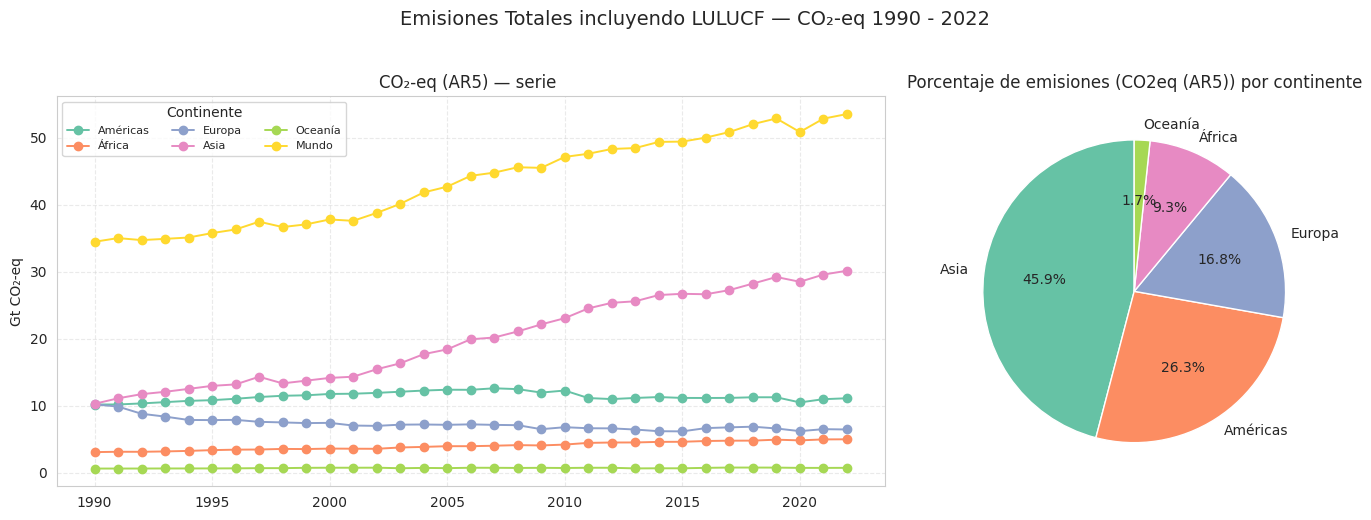

In [ ]:
palette = sns.color_palette('Set2', len(continents_and_global))

df_plot = df_emissions_by_continent_year.copy()

sns.set_style("whitegrid")
fig, (ax_line, ax_pie) = plt.subplots(1, 2, figsize=(14, 5),
                                      gridspec_kw={"width_ratios":[2,1]})


for idx, cont in enumerate(continents_and_global):
    sub = df_plot[(df_plot['Área'] == cont)].sort_values('Año')
    ax_line.plot(sub['Año'], sub['Valor_Gt'], marker='o', linewidth=1.4,
                 label=cont, color=palette[idx])

ax_line.set_title('CO₂-eq (AR5) — serie ')
ax_line.set_ylabel('Gt CO₂-eq')
ax_line.set_xlabel('')
ax_line.grid(ls='--', alpha=.4)
ax_line.legend(title='Continente', ncol=3, fontsize=8)


ax_pie.pie(df_emissions_by_continent['Valor_Gt'],
           labels=df_emissions_by_continent['Área'],
           autopct='%1.1f%%',
           startangle=90,
           colors=palette)
ax_pie.set_title('Porcentaje de emisiones (CO2eq (AR5)) por continente')
ax_pie.axis('equal')

plt.suptitle('Emisiones Totales incluyendo LULUCF — CO₂-eq 1990 - 2022',
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

Interpretación:

En el gráfico de la izquierda, podemos observar como fueron evolucionando las emisiones totales de CO2 eq (AR5) en cada continente desde 1990 a 2022. Cada línea muestra las emisiones en gigatoneladas para cada continente.
En el gráfico de torta, se observa cual es el aporte de cada continente en la suma total de emisiones de CO2 eq (AR5) desde 1990 a 2022.

Conslusiones:
- Asia:
  - Aporta el 46 % del total mundial y continúa en crecimiento.
  - Tiene una curva creciente continua que pasa de 10gt en 1990 a 30gt en 2022.
- América:
  - Aporta el 26% del total mundial.
  - Ligero crecimiento hasta 2005 (aprox 12Gt) y luego hay una meseta hasta el año 2010, donde se observa un descenso de las emisiones.
- Europa:
  - Disminución sostenida desde el año 1990 hasta la actualidad.
- África:
  - Aporta el 9% del total de las emisiones de 1990 - 2022.
  - Tiene un crecimiento sostenido de aprox 3Gt a 5Gt (60%). Pero con una aceleración mucho menor a la de Asia.  
- Oceanía:
  - Es el continente con menos emisiones y se observa una línea plana desde 1990 a la actualidad.


Asia y América representan el 72% del total de emisiones desde 1990 a 2022.
Europa mantiene una reducción constante de las emisiones.

### Distribución porcentual anual de emisiones por continente.

In [ ]:
world = df_emissions_by_continent_year[df_emissions_by_continent_year['Área'] == 'Mundo']
conts = df_emissions_by_continent_year[df_emissions_by_continent_year['Área'] != 'Mundo']

In [ ]:
df_share = conts.merge(world, on='Año', suffixes=('_cont', '_world'))
df_share['share'] = df_share['Valor_Gt_cont'] / df_share['Valor_Gt_world'] * 100


In [ ]:
pivot = (
    df_share.pivot(index='Año', columns='Área_cont', values='share')
            .loc[:, ['Asia','Américas','Europa','África','Oceanía']]
            .fillna(0)
)

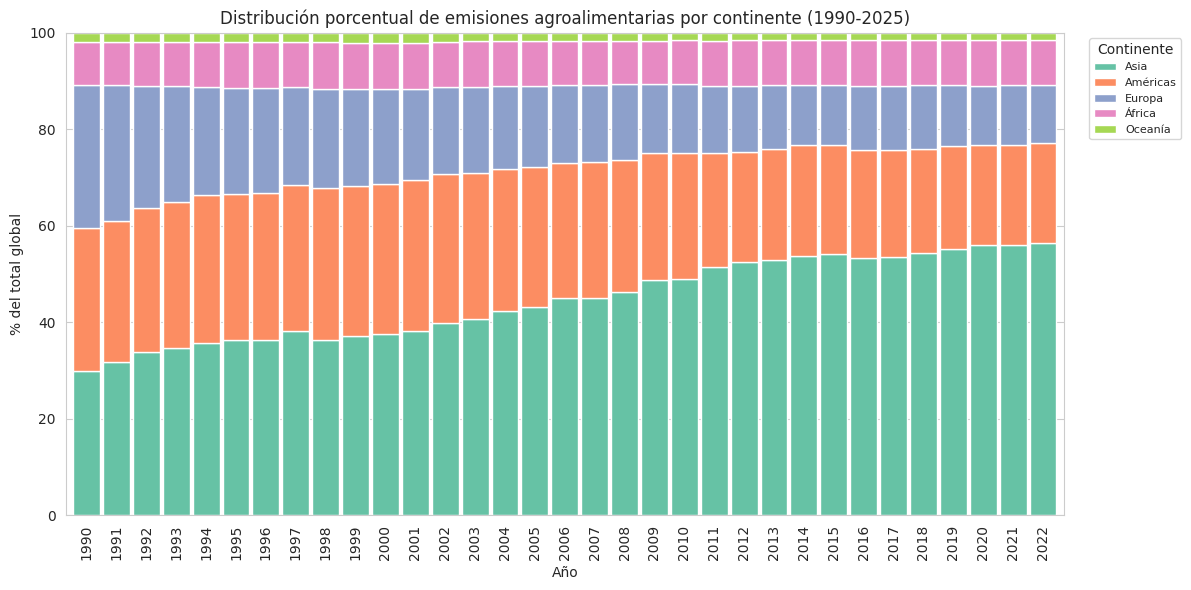

In [ ]:
sns.set_style('whitegrid')
palette = sns.color_palette('Set2', len(pivot.columns))

pivot.plot(kind='bar', stacked=True, figsize=(12,6), color=palette, width=0.9)

plt.title('Distribución porcentual de emisiones agroalimentarias por continente (1990-2025)')
plt.ylabel('% del total global')
plt.xlabel('Año')
plt.ylim(0, 100)
plt.legend(title='Continente', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

Interpretación:
- Cada barra del gráfico representa el 100 % del total global de emisiones. Los colores muestran el porcentaje que ocupa cada continente en ese año.

Conslusiones:
- Asia: pasa de representar un 30% en 1990 a  apoximadamente un 55% en la actualidad.
- América: mantiene aproximadamente un 30% en toda la década del 90, luego cae al 23% en 2010 y se estabiliza.
- Europa: pasa de 29 % en 1990 a <15 % en 2022. La franja azul confirma la eficacia de sus políticas contra la emisión de gases de efecto invernadero.
- África: crece muy lentamente: de 8 % a 9 %
- Oceanía: en 32 años (1990 - 2022) nunca superó el 2%.

Como se puede observar en el gráfico, el eje de las emisiones se desplazó del Atlántico (Europa - América) al Índico - Pacífico. Asia es hoy el principal emisor absoluto y relativo. Además, es el motor del crecimiento de las emisiones a nivel global.

### Promedio Anual de Emisiones Totales por década y continente

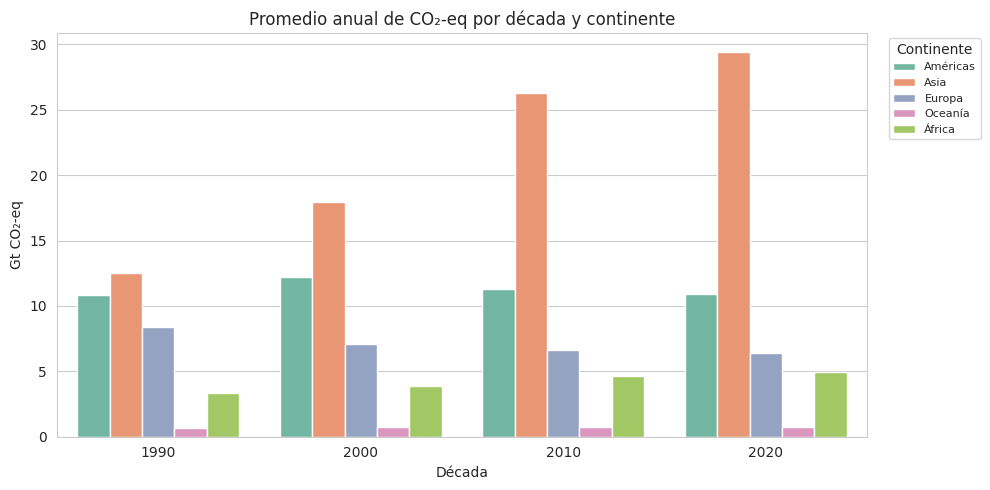

In [ ]:
df_dec = df_emissions_by_continent_year.copy()
df_dec['Década'] = (df_dec['Año'] // 10) * 10
df_dec = df_dec[df_dec['Área'] != 'Mundo']
pivot_dec = (
    df_dec.groupby(['Década','Área'])['Valor_Gt']
          .mean()
          .reset_index()
)

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
sns.barplot(data=pivot_dec,
            x='Década', y='Valor_Gt', hue='Área', palette='Set2')
plt.title('Promedio anual de CO₂-eq por década y continente')
plt.ylabel('Gt CO₂-eq'); plt.xlabel('Década')
plt.legend(title='Continente', bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
plt.tight_layout(); plt.show()

Interpretación:
- Década del 90: el mapa de las emisiones está muy distribuido, no se observa una dominancia marcada por algún continente.
- Década del 2000: Asia despega, aumenta el promedio anual en un 45% respecto a la década anterior (del 12 Gt a 18 Gt). Además, América aumenta un 10% y Europa tiene una caída del 15%. Comienza el cambio a nivel mundial del mapa de emisiones, las mismas se trasladan hacía el pacífico.
- Decada del 2010: Asia acelera nuevamente aumentando otro 45% (de 18gt a 26gt) el promedio anual en la década. En esta década Asia tiene un promedio mayor al doble que América. Europa continúa con su descenso y África aumenta su promedio en un 25% respecto a la década anterior.
- Década del 2020: el promedio anual de Asia se ubica cerca de las 30Gt, triplicando a América. Europa se estabiliza y Oceanía mantiene su promedio anual < 1 Gt, al igual que en décadas anteriores.

### Comparativa de Emisiones por Continente y por componente (1990 - 2010 - 2022)

Para este análisis se seleccionaron los siguientes componentes:

- Farm Gate: fermentación entérica, gestión de estiércol, fertilizantes sintéticos, uso de energía en la finca, etc.
Es decir, es todo lo que ocurre dentro del establecimiento agropecuario.
- Cambios en el uso de la tierra: deforestación, conversión neta de bosques, drenaje de suelos orgánicos, incendios, etc.
- Pre y post-producción: procesado, envasado, transporte, venta y desperdicio de alimentos. Todo lo que sucede antes y después de la puerta de la finca

Estos componentes agrupados representan las Emisiones Totales incluyendo LULUCF. Al analizarlos por separado, podemos definir con precisión qué porción de las emisiones proviene de la finca, de la conversión de ecosistemas o de la cadena de suministro, lo cual es información importante para definir politicas eficaces en cada región.






In [ ]:
continents = ['Américas', 'Asia', 'Europa', 'Oceanía', 'África']

In [ ]:
products = ['Farm gate','Cambios de uso de la tierra', 'Pre y\xa0post-producción' ]
gas = "Emisiones (CO2eq) (AR5)"

In [ ]:
years = [1990, 2010, 2022]

In [ ]:
df_products_continents = df_fao[
    (df_fao['Producto'].isin(products)) &
    (df_fao['Área'].isin(continents)) &
    (df_fao['Año'].isin(years)) &
    (df_fao['Elemento'] == gas)
  ].copy()

In [ ]:
pivot = (
    df_products_continents
      .pivot_table(index=['Año','Área'],
                     columns='Producto',
                     values='Valor_Gt',
                     aggfunc='sum')
        .sort_index(level = 1)
        .reset_index()
)


In [ ]:
pivot = pivot.sort_values(['Área', 'Año'], ascending=[True, False]).reset_index(drop=True)

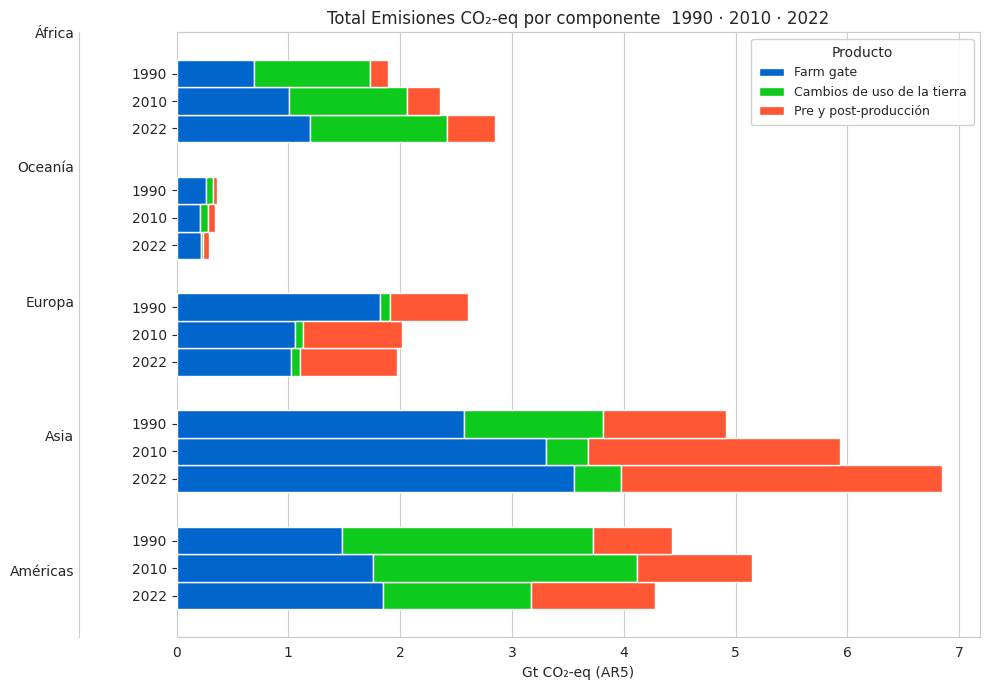

In [ ]:
colors = ['#0066CC', '#0eca1c', '#ff5733']

bar_h = 0.8
gap = 1
offset = bar_h
n_y   = len(years)
y_pos = []
for g in range(len(continents)):
    base = offset + g*(n_y*bar_h + gap)
    y_pos.extend(base + np.arange(n_y)*bar_h)

fig, ax = plt.subplots(figsize=(10,7))
left = np.zeros(len(y_pos))
for (col, color) in zip(products, colors):
    ax.barh(y_pos, pivot[col], left=left,
            height=bar_h, color=color, edgecolor='white', label=col)
    left += pivot[col].values


ax.set_yticks(y_pos)
ax.set_yticklabels(pivot['Año'])
ax.set_axisbelow(True)
ax.grid(axis = 'y')

ax2 = ax.twinx()
mid_pos = [offset*0.1 + g*(n_y*bar_h + gap) + (n_y*bar_h) - bar_h
           for g in range(len(continents))]
ax2.set_yticks(mid_pos)
ax2.set_yticklabels(continents, fontsize=15, weight='bold')


ax2.yaxis.set_ticks_position('left')
ax2.spines['left'].set_position(('outward', 70))
ax2.tick_params(axis='y', length=0)
ax.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(False)


ax.set_xlabel('Gt CO₂-eq (AR5)')
ax.set_title('Total Emisiones CO₂-eq por componente  1990 · 2010 · 2022')
ax.legend(title='Producto',
          loc='upper right',
          frameon=True,
          framealpha=.9,
          borderpad=.6, fontsize=9)
plt.tight_layout()
plt.show()



El gráfico muestra barras horizontales apiladas que cuantifican las emisiones agro-alimentarias de CO₂-equivalente (Gt CO₂-eq) para cada continente en tres cortes temporales: 1990, 2010 y 2022.


Interpretación:

- Asia:

  - En 1990 las emisiones a causa de farm gate es la porción más grande.

  - Para 2022 el bloque rojo (pre-/post-producción) crece con rapidez (aumenta × 7 en 32 años ) reflejando la industrialización de la cadena alimentaria asiática y el aumento del consumo urbano.

  - Las emisiones por cambios en el uso de la tierra se reducen moderadamente tras 2010 gracias a freno parcial de la deforestación en el Sudeste Asiático.

- Américas:

  - En 1990 se observa una dominancia de las emisiones por cambios en el uso de la tierra.
  - Para el año 2022 el bloque verde disminuye notablemente, mientras las emisiones por pre y post-producción se multiplican. Esto significa que hubo una transición de deforestación a cadena de suministro.
  - Al mismo tiempo, azul se mantiene estable y rojo se multiplica. Significa que la presión climática migra de la frontera agropecuaria hacia la logística y el consumo.


- Europa:
   - Desde 1990 a la actualidad, las emisiones por cambios en el uso de la tierra fueron marginales. Es decir
   - Al mismo tiempo, se observa una disminución de las emisiones por farm gate desde 1990 a 2010 y luego se mantienen estables hasta el 2022.
   - El bloque rojo demuestra que la mayor parte del problema europeo reside hoy en las emisiones por pre y post-producción

- África:
  - Las emisiones por farm gate ganan peso década tras década.
  - En 1990 las emisiones por cambios en el uso de la tierra dominan con amplia ventaja.
  - En 2010 las emisiones por farm gate recortan distancia.
  - En 2022, el componente ligado a deforestación e incendios sigue siendo la principal fuente de emisiones. Además, la franja roja (pre y post-produccion) muestra que la cadena de valor —procesado, transporte, venta está comenzando a pesar y puede acelerarse.

- Oceanía: emisiones muy bajas y estables


Conclusión:
- El problema climático del sistema agro‑alimentario mundial se ha desplazado del “dónde sembramos” (deforestación) al “cómo producimos y consumimos” (industria y consumo).
Las estrategias para reducir las emisiones de gases deben, por tanto, abarcar la cadena completa, con prioridades distintas según la fase en que se encuentre cada región.


### Top 10 Paises con mayores Emisiones (CO2eq) (AR5) (2022)

Para este análisis se seleccionó el elemento Emisiones (CO2eq) (AR5), ya que:
- Es una métrica que convierte todas las emisiones de gases de efecto invernadero (GEI) —como dióxido de carbono (CO₂), metano (CH₄) y óxido nitroso (N₂O)— en toneladas equivalentes de CO₂.
- Permite realizar análisis agregados, consistentes y comparables entre países



In [ ]:
gas = 'Emisiones (CO2eq) (AR5)'
product_code = 6825 # Emisiones Totales incluyendo LULUCF

In [ ]:
df_countries_2022 = df_fao[
    (~df_fao['Área'].isin(regiones)) &
    (df_fao['Código del producto'] == product_code) &
    (df_fao['Elemento'] == gas) &
    (df_fao['Año'] == 2022)
    ]

In [ ]:
df_top_countries_emission = df_countries_2022.groupby(['Área'])['Valor'].sum().reset_index()
df_top_countries_emission.sort_values(by= 'Valor',ascending=False, inplace=True)
df_top_countries_emission = df_top_countries_emission.head(10)
df_top_countries_emission

,Área,Valor
40,China,1.435490e+07
63,Estados Unidos de América,5.801633e+06
91,India,4.132523e+06
67,Federación de Rusia,2.173420e+06
92,Indonesia,1.850634e+06
27,Brasil,1.682968e+06
115,Japón,1.113600e+06
95,Irán (República Islámica del),1.005281e+06
7,Arabia Saudita,9.291635e+05
148,México,8.355194e+05


In [ ]:
total_global = df_fao[
    (df_fao['Elemento'] == 'Emisiones (CO2eq) (AR5)') &
    (df_fao['Área'] == 'Mundo') &
     (df_fao['Año'] == 2022) &
    (df_fao['Código del producto'] == product_code)
    ]['Valor'].sum()
total_top_10 = df_top_countries_emission['Valor'].sum()

In [ ]:
pct_top_10 = (total_top_10 / total_global) * 100
pct_rest = 100 - pct_top_10
pct_top_10, pct_rest

(np.float64(63.313737483328595), np.float64(36.686262516671405))

In [ ]:
fix = {
    "Estados Unidos de América": "EEUU",
    "Irán (República Islámica del)": 'Irán',
    "Federación de Rusia": "Rusia"
}
df_top_countries_emission['Área'] = df_top_countries_emission['Área'].replace(fix)

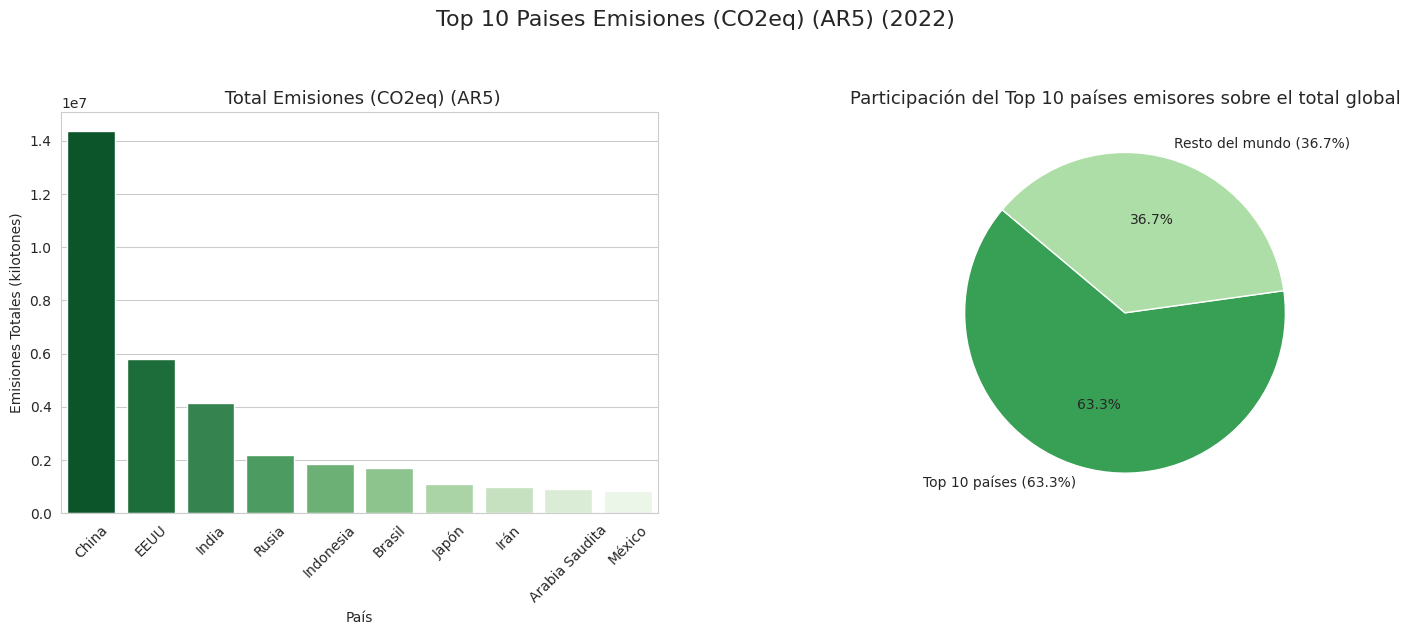

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6),gridspec_kw={'width_ratios': [1.2, 1]})

sns.barplot(data=df_top_countries_emission,x='Área', y='Valor', hue='Área',
            palette='Greens_r', ax=axs[0], legend=False)
axs[0].set_title(' Total Emisiones (CO2eq) (AR5)', fontsize=13)
axs[0].set_xlabel('País')
axs[0].set_ylabel('Emisiones Totales (kilotones)')
axs[0].tick_params(axis='x', rotation=45)

labels = [f'Top 10 países ({pct_top_10:.1f}%)', f'Resto del mundo ({pct_rest:.1f}%)']
values = [pct_top_10, pct_rest]

axs[1].pie(
    x=values,
    labels=labels,
    colors=sns.color_palette('Greens_r', len(labels)),
    startangle=140,
    autopct=lambda p: f'{p:.1f}%'
)
axs[1].set_title('Participación del Top 10 países emisores sobre el total global', fontsize=13)

fig.suptitle('Top 10 Paises Emisiones (CO2eq) (AR5) (2022)', fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

Interpretación:

- China	Con aproximadamente 14 millones de kt lidera con enorme ventaja ( 2,5 × EEUU).
- EE. UU: es el segundo país con mas emisiones en el mundo pero, aun así emite menos de la mitad que China.
- India: se consolida en el tercer lugar, reflejando crecimiento poblacional.
- Rusia, Indonesia, Brasil, Japón, Irán: tienen valores intermedios (0,6 – 2 millones kt). Mezcla de grandes potencias agrícolas (Brasil, Indonesia) y economías industriales/energéticas (Rusia, Irán, Japón).
- Arabia Saudita y México	ocupan el puesto 9 y 10 el ranking. Sus emisiones son <10 % de las chinas.

Se puede observar una desigualdad extrema: el primer país (China) emite casi 75 veces más que el décimo.

Además, en el gráfico de la derecha podemos observar que, en la actualidad, dos tercios de todas las emisiones agro‑alimentarias se concentran en solo diez países (63%). Por lo tanto, el resto de los paises (180 aprox) aportan el otro tercio.
El gráfico demuestra que las politicas de mitigación global deben hacer foco en unas pocas jurisdicciones. Sin acciones contundentes en esos países, el resto del mundo difícilmente compensará el volumen de emisiones que ahí se genera.

### Emisiones 2022 — Productos más emisores por país
Heatmap de productos x paises

Cada celda nos muestra las Emisiones (CO2eq) (AR5) en el año 2022 de cada producto en cada país.
Esto nos permite ver que paises son más emisores en cada proceso y ver los procesos críticos de cada región, lo cual permite priorizar acciones.

Para este análisis, seleccionamos los 6 paises con más emisiones en el año 2022 (China, EEUU, India, Rusia, Indonesia y Brasil). Estos países representan el 56% del total de emisiones incluyendo LULUCF a nivel global en el año 2022.

In [ ]:
regions = ['China', 'Estados Unidos de América', 'India','Indonesia', 'Brasil', 'Federación de Rusia']

In [ ]:
df_2022 = (
    df_fao[
        (df_fao['Año'] == 2022) &
        (df_fao['Área'].isin(regions)) &
        (df_fao['Elemento'] == 'Emisiones (CO2eq) (AR5)') &
        (~df_fao['Código del producto'].isin(codes_agg))
    ]
    .copy()
)


In [ ]:
fix = {
    "Eliminación de desechos de sistemas agroalimentarios": "Eliminación desechos sist. agro",
}
fix_countries = {
    'Estados Unidos de América': 'EEUU',
    'Federación de Rusia': 'Rusia',
}
df_2022['Producto'] = df_2022['Producto'].replace(fix)
df_2022['Área'] = df_2022['Área'].replace(fix_countries)


In [ ]:
top_products = (
    df_2022.groupby('Producto')['Valor_Mt'].sum()
           .nlargest(15).index
)

df_2022 = df_2022[df_2022['Producto'].isin(top_products)]
pivot = (
    df_2022
      .pivot_table(index='Producto', columns='Área',
                   values='Valor_Mt', aggfunc='sum')
      .fillna(0)
      .sort_values('China', ascending=False)
)

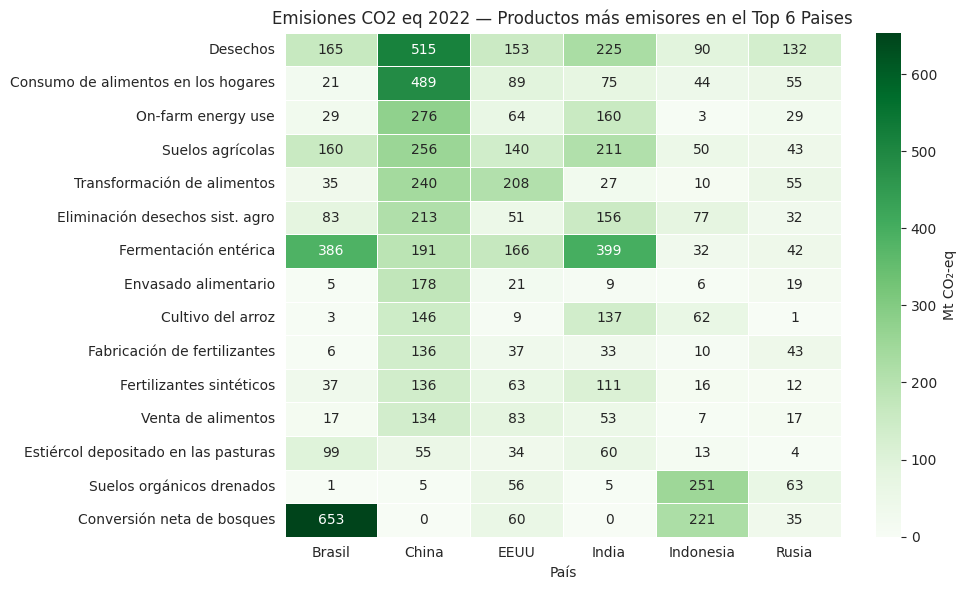

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Greens',
            linewidths=.5, linecolor='white', cbar_kws={'label':'Mt CO₂-eq'})
plt.title('Emisiones CO2 eq 2022 — Productos más emisores en el Top 6 Paises')
plt.xlabel('País'); plt.ylabel('')
plt.tight_layout()
plt.show()

Conslusiones:
- China: el grueso de las emisiones no proviene del campo, sino de la cadena poscosecha y el consumo urbano (desechos y consumo de alimentos).
- EEUU: tiene valores medianos-altos en casi todas las filas. No tiene un pico, por lo tanto las medidas de acción deberían ser aplicadas de manera multisectorial.
- India: las emisiones se encuentran diversificadas. Es el mayor emisor por fermentación entérica. Además, el consumo de energía dentro de la finca ya supera a la mayoría de los procesos pos-cosecha.
- Indonesia: picos sobresalientes en suelos orgánicos drenados y conversión neta de bosques. El drenaje y la quema de turberas  para palma aceitera liberan grandes cantidades de CO2.
https://rspo.org/es/the-challenges-of-growing-oil-palm-on-peatlands/
- Rusia: sin celdas mayores a 200 Mt, se destacan las emisiones por desechos y suelos orgánicos. Tiene un perfil más parecido al de Europa que al de Brasil/Indonesia.
- Brasil: el cambio en el uso del suelo es el motor de las emisiones. Otro pico alto es la fermentación entérica.


Conclusiones generales:
- No hay una única fuente de emisión que domine en todos los paises. Cada economía tiene su debilidad.
- China y EEUU tienen mayor contaminación en procesos pos-producción (desechos, consumo), mientras Brasil e Indonesia tienen mayores problemas en el sector agrícola.
- Cuatro de los seis paises tienen emisiones mayores a 150 mt por fermentación entérica, esto indica que la ganadería es un motor de contaminación a nivel global.

### América (Actualidad)

In [ ]:
anio = 2022
countries = ['Estados Unidos de América', 'Brasil', 'Argentina', 'México', 'Colombia', 'Canadá', 'Perú']
product_code = 6825 # Emisiones totales incluyendo LULUCF
gas = 'Emisiones (CO2eq) (AR5)'

In [ ]:
df_most_population_america = df_fao[
    (df_fao['Área'].isin(countries)) &
    (df_fao['Año'] == anio) &
    (df_fao['Elemento'] == gas) &
    (df_fao['Código del producto'] == product_code)]

In [ ]:
df_top_countries_emission = df_most_population_america.groupby(['Área'])['Valor_Mt'].sum().reset_index()
df_top_countries_emission.sort_values(by= 'Valor_Mt',ascending=False, inplace=True)

In [ ]:
total_america = df_fao[
    (df_fao['Área'] == 'Américas') &
    (df_fao['Año'] == anio) &
     (df_fao['Elemento'] == gas) &
    (df_fao['Código del producto'] == product_code)
    ]['Valor_Mt'].sum()

In [ ]:
rest_of_america = total_america - df_top_countries_emission['Valor_Mt'].sum()

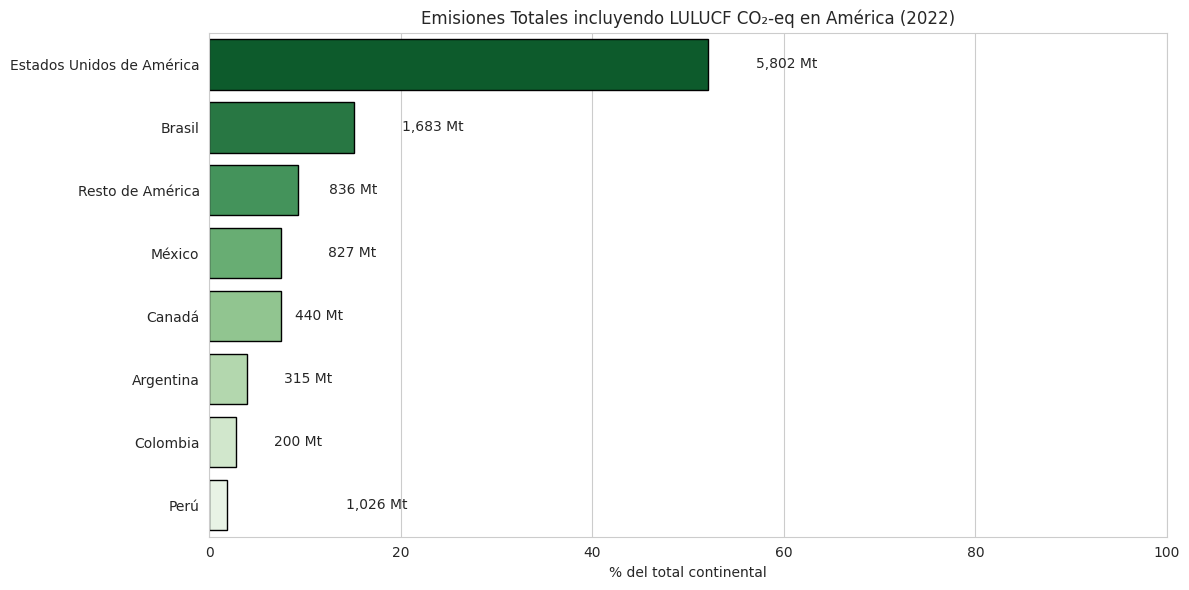

In [ ]:
df_plot = (pd.concat(
    [df_top_countries_emission ,
     pd.DataFrame({'Área': ['Resto de América'], 'Valor_Mt': [rest_of_america]})
     ], ignore_index=True)
)

df_plot['Share'] = (df_plot['Valor_Mt'] / df_plot['Valor_Mt'].sum()) * 100
df_plot.sort_values('Valor_Mt', ascending=False, inplace=True)

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, y='Área', x='Share', hue='Área',
            palette='Greens_r', edgecolor='black')

for i, row in df_plot.iterrows():
    plt.text(row['Share']+5, i,
             f"{row['Valor_Mt']:,.0f} Mt", va='center')

plt.title(f'Emisiones Totales incluyendo LULUCF CO₂-eq en América ({anio})')
plt.xlabel('% del total continental'); plt.ylabel('')
plt.xlim(0, 100)
plt.tight_layout(); plt.show()

###Análisis por Tipo de Gas y Continente

In [ ]:
gases = ['Emisiones (CO2)', 'Emisiones (N2O)', 'Emisiones (CH4)']

In [ ]:
df_continents_gas = df_fao[
    (df_fao['Área'].isin(continents)) &
    (df_fao['Elemento'].isin(gases)) &
    (df_fao['Producto'] == 'Emisiones totales incluyendo LULUCF')# totales incluyendo emisiones por uso del suelo, cambio de uso y silvicultura (Land Use, Land-Use Change and Forestry)
    ].copy()

In [ ]:
df_continents_gas_by_year = df_continents_gas.groupby(['Área', 'Elemento', 'Año'])['Valor_Mt'].sum().reset_index()
df_continents_gas_by_year = df_continents_gas_by_year[df_continents_gas_by_year['Área'] != 'Mundo']
df_continents_gas_by_year.sort_values(by='Valor_Mt', ascending=False, inplace=True)


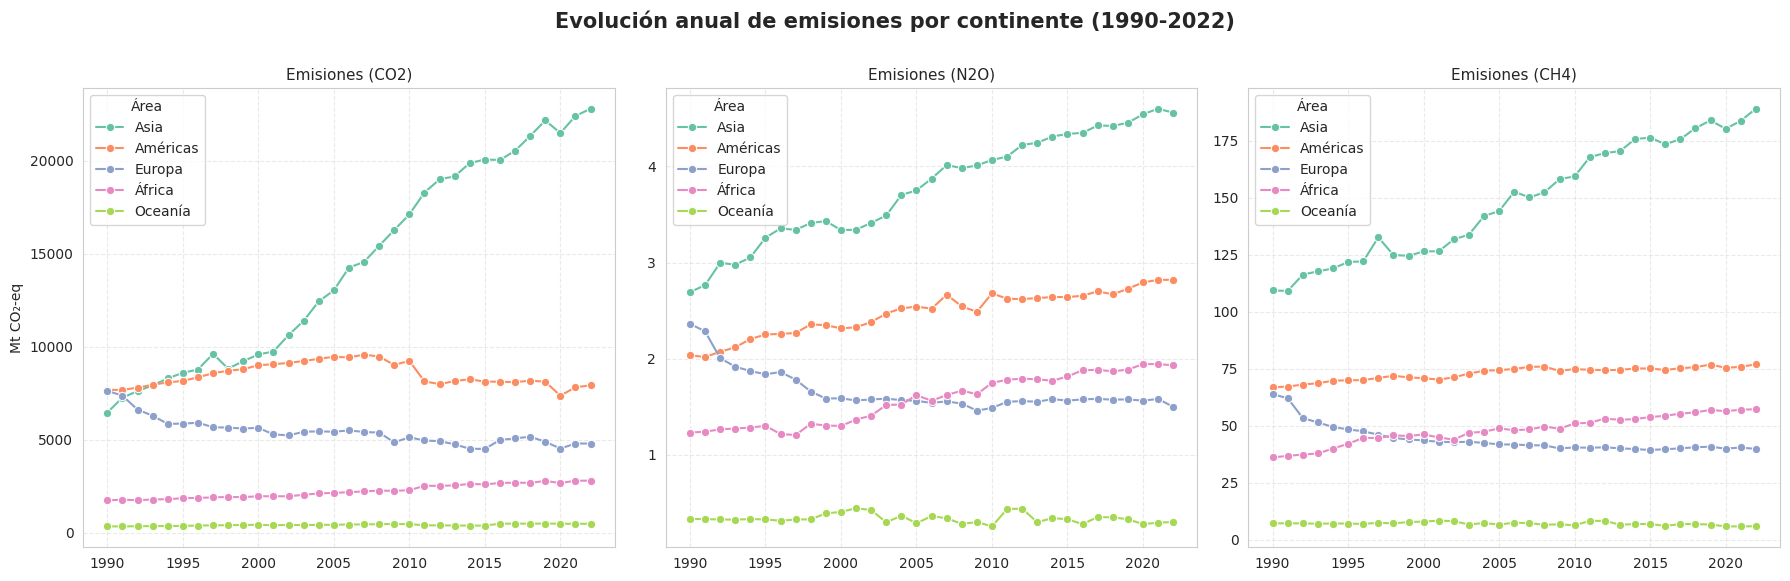

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs = axs.ravel()

palette = sns.color_palette('Set2', len(continents))

for i, gas in enumerate(gases):
    ax = axs[i]
    sns.lineplot(data=df_continents_gas_by_year[df_continents_gas_by_year['Elemento'] == gas],
                 x='Año', y='Valor_Mt', hue='Área',
                 marker='o', palette=palette, ax=ax)

    ax.set_title(gas, fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('Mt CO₂-eq')
    ax.grid(ls='--', alpha=.4)
    if i == 0:
        ax.set_ylabel('Mt CO₂-eq')
    else:
        ax.set_ylabel('')
fig.suptitle('Evolución anual de emisiones por continente (1990-2022)',
             fontsize=15, weight='bold', y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Asia: es el motor del alza mundial de los tres gases. La pendiente apenas se modera a partir de 2015. Las emisiones de CO2 crecen de 6 mil Mt a casi 23 mil Mt.

América: las emisiones de CO2 crecen hasta 2005 y luego hay una meseta-descenso a 8000 mt. Las emisiones de NO2 tienen un crecimiento suave de 2 mil Mt a casi 3mil Mt. Mientras que las emisiones de CH4, se mantienen estables.

Europa: es el único continente donde se observa una caída en las emisiones de los tres gases.

África: el salto porcentual es grande (sobretodo en CH4 y N2O), pero la magnitud absoluta sigue muy por debajo de Asia o América. Las emisiones de CO2 crecen muy lentamente.

Oceanía: impacto global muy bajo. Las variaciones anuales están relacionadas a incendios o sequías.


Conclusiones generales:
- N2O es el gas con la pendiente proporcional más alta en África y Asia: es la línea que mas rápido crece en ambos continentes.
- CH4 presenta tendencia ascendente suave excepto en Europa que hay un descenso.
-CO₂ es, con mucha diferencia, el gas dominante en todas las regiones.

### Análisis de Productos Desagregados y su relación con los diferentes tipos de Gas (2022)
Para este análisis vamos a tener en cuenta los productos desagregados


In [ ]:
gases = ['Emisiones (CO2)', 'Emisiones (N2O)', 'Emisiones (CH4)']
anio = 2022

In [ ]:
df_non_agg_products = df_fao[
    (~df_fao['Código del producto'].isin(codes_agg)) &
    (df_fao['Año'] == anio) &
    (df_fao['Elemento'].isin(gases))
    ]

In [ ]:
df_products_top_emissions = df_non_agg_products.groupby(['Producto', 'Elemento'])['Valor_Mt'].sum().reset_index()

In [ ]:
top_n = 10
lista_top = []
for g in gases:
    top_g = (df_non_agg_products[df_non_agg_products['Elemento'] == g]
                .groupby('Producto')['Valor_Mt']
                .sum()
                .sort_values(ascending=False)
                .head(top_n)
                .reset_index())
    top_g['Gas'] = g
    lista_top.append(top_g)

df_top_gases = pd.concat(lista_top, ignore_index=True)

df_top_gases = (df_top_gases.set_index(['Gas','Producto'])
                              .sort_index(level='Gas'))

In [ ]:
df_top_gases = df_top_gases.rename(
    index={'Eliminación de desechos de sistemas agroalimentarios':
           'Eliminación de desechos de S. Agro.'},
    level='Producto'
)

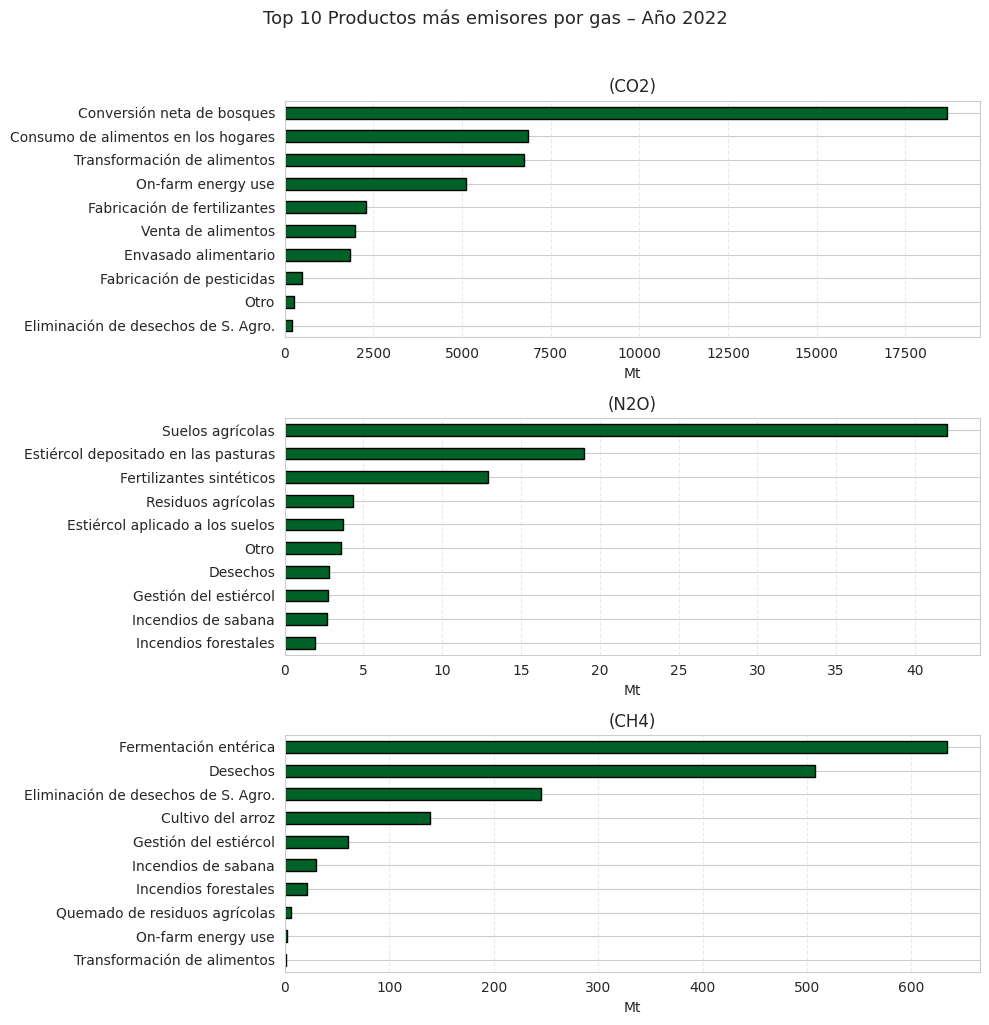

In [ ]:
sns.set_style('whitegrid')
base_palette = sns.color_palette('Greens_r', top_n)
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=False)

for ax, g in zip(axes, gases):
    sub = df_top_gases.loc[g].sort_values('Valor_Mt')
    colors = base_palette
    sub.plot.barh(ax=ax, color=colors, edgecolor='black')
    ax.set_title(f'{g.split()[1]}')
    ax.set_xlabel('Mt'); ax.set_ylabel('')
    ax.grid(axis='x', ls='--', alpha=.4)
    ax.get_legend().remove()

fig.suptitle('Top 10 Productos más emisores por gas – Año 2022', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

# Modelo Predictivo

El siguiente modelo estima las emisiones totales incluyendo LULUCF (Uso de la Tierra, Cambio de Uso de la Tierra y Silvicultura) para cada continente. Se utilizan los datos desde 1990 a 2022 para proyectar como van a evolucionar esas emisiones en los proximos años.

In [ ]:
serie = df_fao[
    (df_fao['Elemento'] == 'Emisiones (CO2eq) (AR5)') &
    (df_fao['Código del producto'] == 6825)
  ].copy()

serie_america = serie[serie['Área'] == 'Américas']
serie_asia = serie[serie['Área'] == 'Asia']
serie_europa = serie[serie['Área'] == 'Europa']
serie_oceania = serie[serie['Área'] == 'Oceanía']
serie_africa = serie[serie['Área'] == 'África']

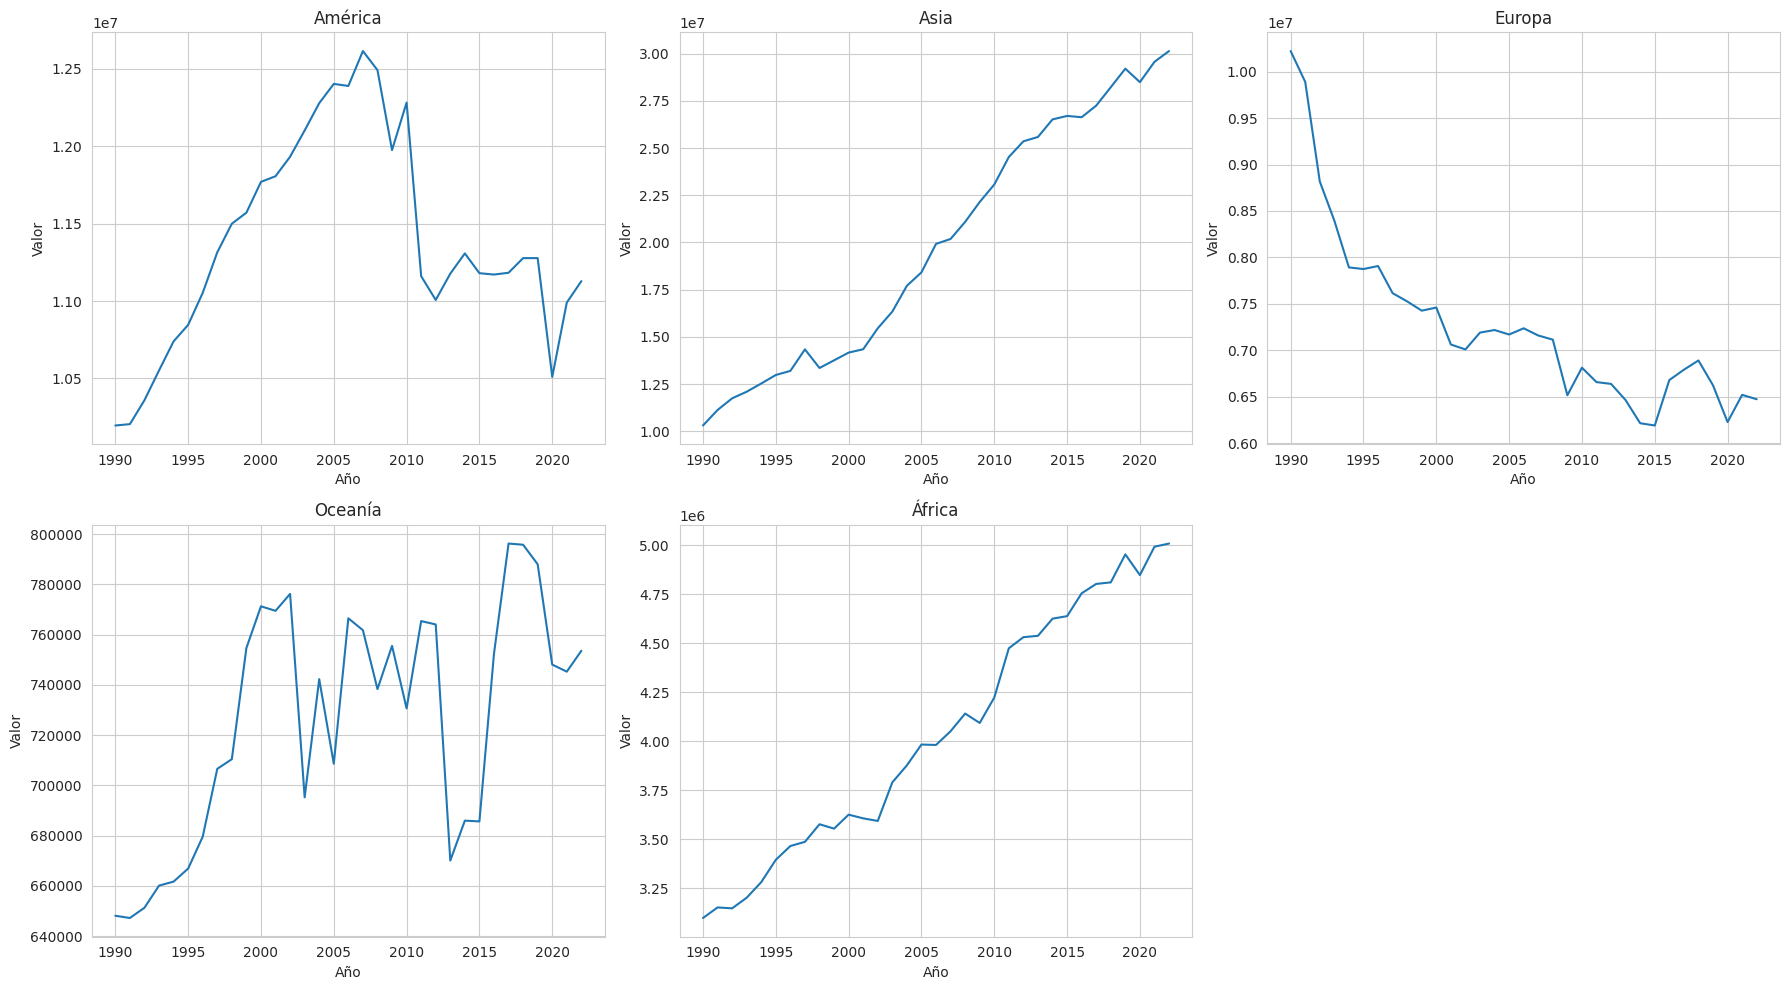

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sns.lineplot(data=serie_america, x='Año', y='Valor', ax=axes[0])
axes[0].set_title('América')

sns.lineplot(data=serie_asia, x='Año', y='Valor', ax=axes[1])
axes[1].set_title('Asia')

sns.lineplot(data=serie_europa, x='Año', y='Valor', ax=axes[2])
axes[2].set_title('Europa')

sns.lineplot(data=serie_oceania, x='Año', y='Valor', ax=axes[3])
axes[3].set_title('Oceanía')

sns.lineplot(data=serie_africa, x='Año', y='Valor', ax=axes[4])
axes[4].set_title('África')

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


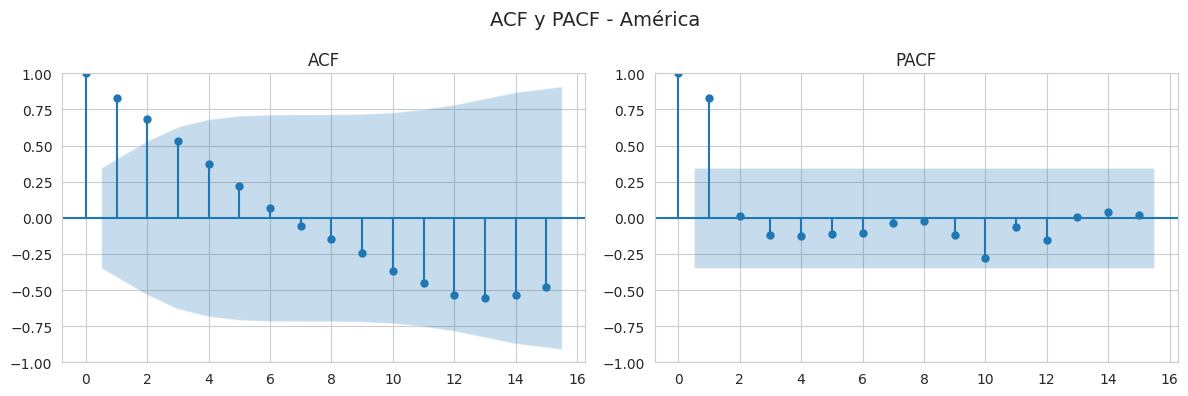

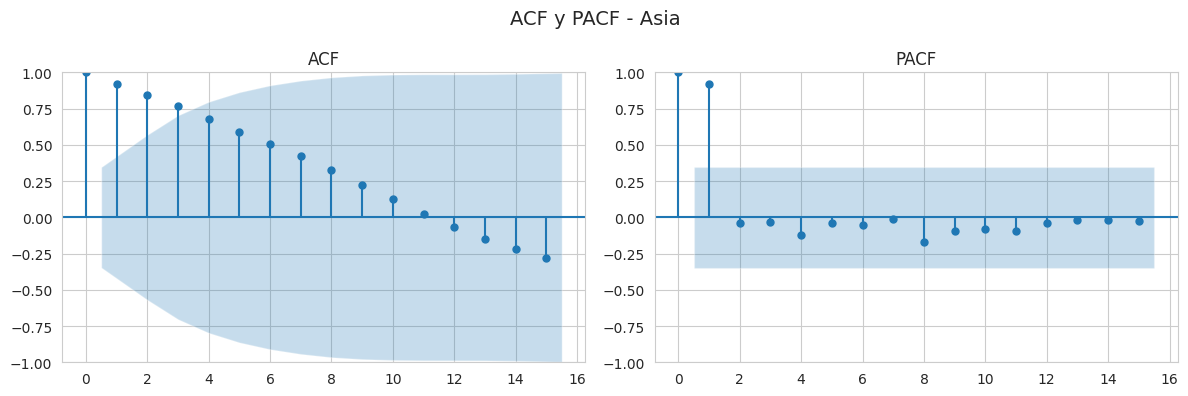

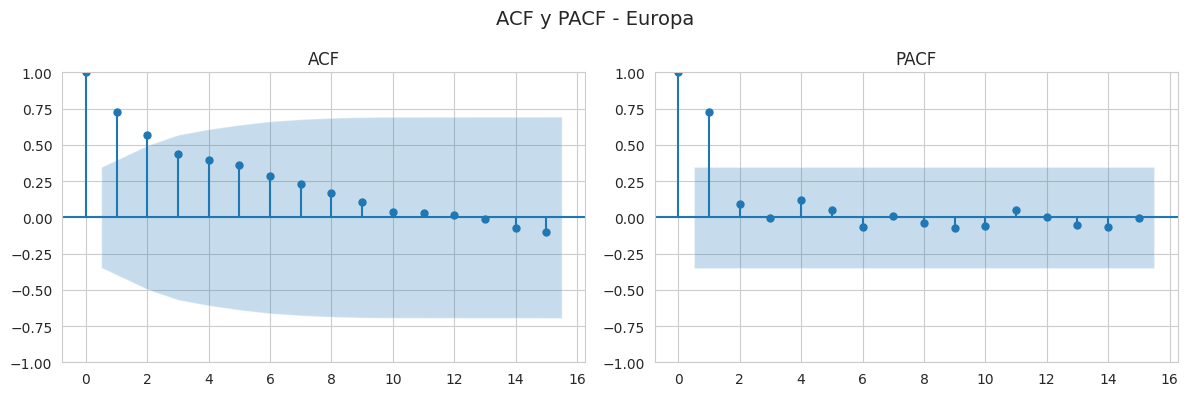

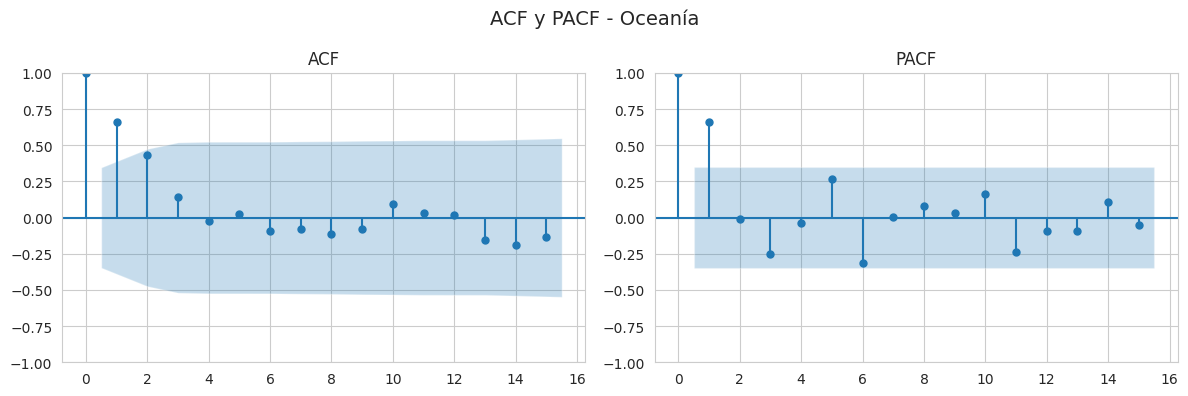

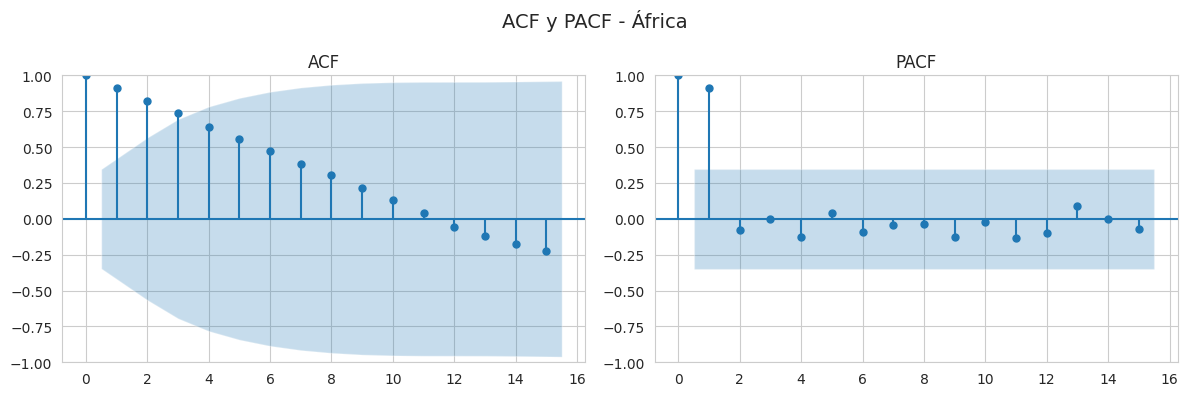

In [ ]:
series = [
    ('América', serie_america),
    ('Asia', serie_asia),
    ('Europa', serie_europa),
    ('Oceanía', serie_oceania),
    ('África', serie_africa)
]
for (nombre, df) in series:

    serie = df['Valor'].dropna()
    if len(serie) < 10:
        print("Muy pocos datos para mostrar ACF/PACF confiables\n")
        continue

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'ACF y PACF - {nombre}', fontsize=14)

    plot_acf(serie, lags=15, ax=ax[0])
    plot_pacf(serie, lags=15, ax=ax[1])

    ax[0].set_title('ACF')
    ax[1].set_title('PACF')

    plt.tight_layout()
    plt.show()

Conclusiones:

ACF: mide cuánta memoria tiene la serie. En los gráficos se puede ver que las barras bajan de a poco, esto quiere decir que lo que pasó años anteriores todavía pesa hoy. Es una característica de series no estacionarias.

PACF: muestra las influencias directas. Ejemplo: Cuánto empuja 2019 a 2020 directamente, sin contar con la ayuda de 2018, 2017…? En los gráficos se observa una barra alta en el lag 1 y 2 que luego caen.




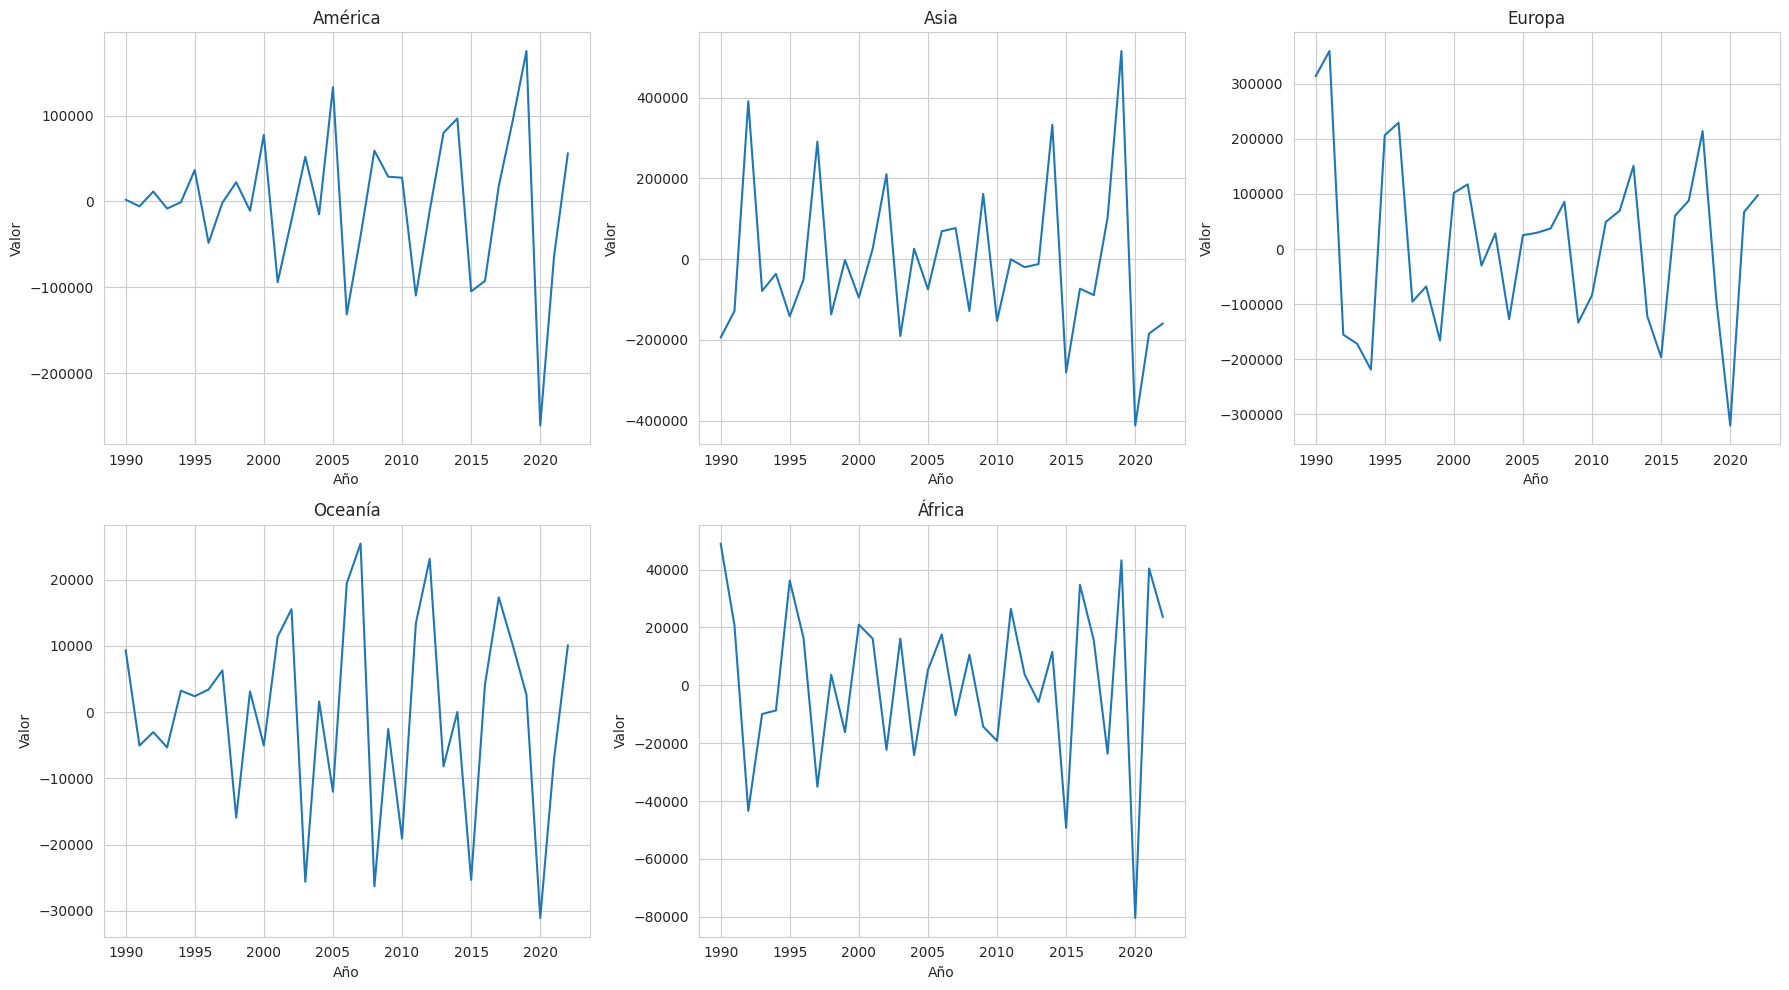

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()


for i, (titulo, serie) in enumerate(series):
    stl = STL(serie['Valor'], period=5).fit()
    axes[i].plot(serie['Año'], stl.seasonal)
    axes[i].set_title(f'{titulo}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Valor')

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()



STL desarma la serie en tres partes: tendencia, estacionalidad y ruido. Intenamos buscar un patrón que se repita cada 5 años.

In [ ]:
print("Var(seasonal América) / Var(original) =",
      round(stl.seasonal.var()/serie_america['Valor'].var(), 3))
print("Var(seasonal Asia) / Var(original) =",
      round(stl.seasonal.var()/serie_asia['Valor'].var(), 3))
print("Var(seasonal Europa) / Var(original) =",
      round(stl.seasonal.var()/serie_europa['Valor'].var(), 3))
print("Var(seasonal Oceanía) / Var(original) =",
      round(stl.seasonal.var()/serie_oceania['Valor'].var(), 3))
print("Var(seasonal África) / Var(original) =",
      round(stl.seasonal.var()/serie_africa['Valor'].var(), 3))

Var(seasonal América) / Var(original) = 0.002
Var(seasonal Asia) / Var(original) = 0.0
Var(seasonal Europa) / Var(original) = 0.001
Var(seasonal Oceanía) / Var(original) = 0.381
Var(seasonal África) / Var(original) = 0.002


La varianza de la componente estacional en América, Asia, Europa y África representa entre el 0.1% y 0.2% del total, por lo que se descarta un patrón estacional significativo. La series de estos continentes están dominadas por la tendencia y el ruido, por lo que, probablemente con una diferenciación sea suficiente.

En el caso de Oceanía el % de la varianza explicada por un ciclo de 5 años es mayor al 38%, por lo que se podría aplicar SARIMA.

## Pruebas de estacionariedad

Una serie estacionaria es aquella en la que las reglas del juego no cambian con el tiempo. Es decir, es aquella serie en la que la media se mantiene estaable, la varianza (cuanto se alejan los valores de la media) tampoco varía, y las correlaciones entre un año y el siguiente tienen siempre la misma fuerza.

En otras palabras, si recortáramos un pedazo de la serie y la comparamos contra otra parte de la misma, se verían estadísticamente iguales.

La estacionariedad es MUY importante para aplicar algunos modelos (ARIMA, SARIMA, etc.), ya que es una condición para que los pronósticos sean confiables.

###Prueba ADF

Aplicamos test de Dickey-Fuller Aumentado (ADF) para verificar si una serie temporal es estacionaria.

In [ ]:
series_continentales = {
    'América': serie_america['Valor'],
    'Asia': serie_asia['Valor'],
    'Europa': serie_europa['Valor'],
    'Oceanía': serie_oceania['Valor'],
    'África': serie_africa['Valor'],
}

# Evaluar ADF en cada serie
for nombre, serie in series_continentales.items():
    print(f'--- {nombre} ---')
    serie = serie.dropna()

    if len(serie) < 3:
        print("Serie vacía o con muy pocos datos, se omite.\n")
        continue

    try:
        result = adfuller(serie)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print(f'Critical Value ({key}): {value}')

        if result[1] < 0.05:
            print("→ La serie **es estacionaria** (rechaza H0)\n")
        else:
            print("→ La serie **NO es estacionaria** (no rechaza H0)\n")
    except Exception as e:
        print(f" Error al procesar: {e}\n")



--- América ---
ADF Statistic: -1.924039111165148
p-value: 0.32083821828059644
Critical Value (1%): -3.653519805908203
Critical Value (5%): -2.9572185644531253
Critical Value (10%): -2.6175881640625
→ La serie **NO es estacionaria** (no rechaza H0)

--- Asia ---
ADF Statistic: 0.09766342584455714
p-value: 0.9659012027822864
Critical Value (1%): -3.653519805908203
Critical Value (5%): -2.9572185644531253
Critical Value (10%): -2.6175881640625
→ La serie **NO es estacionaria** (no rechaza H0)

--- Europa ---
ADF Statistic: -4.483071847392288
p-value: 0.00021096312615175115
Critical Value (1%): -3.653519805908203
Critical Value (5%): -2.9572185644531253
Critical Value (10%): -2.6175881640625
→ La serie **es estacionaria** (rechaza H0)

--- Oceanía ---
ADF Statistic: -2.5449634118695275
p-value: 0.1049138921928
Critical Value (1%): -3.6996079738860943
Critical Value (5%): -2.9764303469999494
Critical Value (10%): -2.627601001371742
→ La serie **NO es estacionaria** (no rechaza H0)

--- Áfr

###Prueba KPSS

In [ ]:
alpha = 0.05 # nivel de significancia
for nombre, serie in series_continentales.items():
    print(f'--- {nombre} ---')
    serie = serie.dropna()

    if len(serie) < 3:
        print("Serie vacía o muy corta, se omite.\n")
        continue

    try:
        stat, p, lags, crit = kpss(serie, regression='ct')
        print(f"KPSS stat={stat:.3f} | p={p:.3f} | lags={lags}")
        if p < alpha:
            print("**NO estacionaria** (se rechaza H₀)\n")
        else:
            print("Sin evidencia contra la estacionaridad (no se rechaza H₀)\n")
    except Exception as e:
        print(f"Error al procesar {nombre}: {e}\n")

--- América ---
KPSS stat=0.217 | p=0.010 | lags=3
**NO estacionaria** (se rechaza H₀)

--- Asia ---
KPSS stat=0.132 | p=0.076 | lags=3
Sin evidencia contra la estacionaridad (no se rechaza H₀)

--- Europa ---
KPSS stat=0.180 | p=0.023 | lags=3
**NO estacionaria** (se rechaza H₀)

--- Oceanía ---
KPSS stat=0.121 | p=0.096 | lags=3
Sin evidencia contra la estacionaridad (no se rechaza H₀)

--- África ---
KPSS stat=0.124 | p=0.091 | lags=3
Sin evidencia contra la estacionaridad (no se rechaza H₀)



### Resultados de las Pruebas de Estacionariedad:

- América: tanto la prueba ADF como KPSS coinciden en que la serie no es estacionaria. Tratamiento: vamos a realizar una diferenciación (d = 1).
- Asia: existe un conflicto leve entre las pruebas. ADF rechaza la estacionariedad, mientras KPSS no la rechaza. Tratamiento: vamos a partir de una primera diferenciación y hacer pruebas.
- Europa: conflicto. KPSS indica que no hay estacionariedad mientras ADF rechaza la H0, indicando lo contrario. Tratamiento: vamos a hacer pruebas luego de una primera diferenciación.
- Oceanía: las pruebas se contradicen. Tratamiento: d = 1.
- África: ADF concluye que la serie no es estacionaria y KPSS no tiene evidencia contra la estacionariedad. Tratamiento: primera diferenciación.


##Diferenciación

¿Para qué sirve?

Es la operación más sencilla para "arreglar" una serie que no es estacionaria. Consiste en restar cada valor con el anterior. Esto permite eliminar tendencias.

In [ ]:
differenced_series = {
    'América': serie_america,
    'Asia': serie_asia,
    'Europa': serie_europa,
    'Oceanía': serie_oceania,
    'África': serie_africa,
}

for nombre, df in differenced_series.items():
  print(f'--- {nombre} ---')

  # Aplicar diferencia
  df['Valor_diff'] = df['Valor'].diff()
  df.dropna(inplace=True)

  if df['Valor_diff'].dropna().size < 3:
      print("No hay suficientes datos para testear la serie diferenciada\n")
      continue
  try:
    # ADF sobre serie diferenciada
    result = adfuller(df['Valor_diff'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
      print(f'Critical Value ({key}): {value}')

    if result[1] < 0.05:
      print("→ La serie **es estacionaria** (rechaza H0)\n")
    else:
      print("→ La serie **NO es estacionaria** (no rechaza H0)\n")
    print('--------')
    # KPSS sobre serie diferenciada
    stat, p, lags, crit = kpss(df['Valor_diff'], regression='ct')
    print(f"KPSS stat={stat:.3f} | p={p:.3f} | lags={lags}")
    if p < alpha:
        print("**NO estacionaria** (se rechaza H₀)\n")
    else:
        print("Sin evidencia contra la estacionaridad (no se rechaza H₀)\n")
  except Exception as e:
    print(f"Error al procesar {nombre}: {e}\n")


--- América ---
ADF Statistic: -5.988738115752402
p-value: 1.7663761765730004e-07
Critical Value (1%): -3.661428725118324
Critical Value (5%): -2.960525341210433
Critical Value (10%): -2.6193188033298647
→ La serie **es estacionaria** (rechaza H0)

--------
KPSS stat=0.095 | p=0.100 | lags=3
Sin evidencia contra la estacionaridad (no se rechaza H₀)

--- Asia ---
ADF Statistic: -5.936965818863856
p-value: 2.3086859912501254e-07
Critical Value (1%): -3.661428725118324
Critical Value (5%): -2.960525341210433
Critical Value (10%): -2.6193188033298647
→ La serie **es estacionaria** (rechaza H0)

--------
KPSS stat=0.139 | p=0.064 | lags=1
Sin evidencia contra la estacionaridad (no se rechaza H₀)

--- Europa ---
ADF Statistic: -4.500543122132178
p-value: 0.00019619603241511778
Critical Value (1%): -3.661428725118324
Critical Value (5%): -2.960525341210433
Critical Value (10%): -2.6193188033298647
→ La serie **es estacionaria** (rechaza H0)

--------
KPSS stat=0.111 | p=0.100 | lags=1
Sin evi

Conclusiones luego de testear la estacionariedad en las series diferenciadas:

- América: ambos test concuerdan. Serie estacionaria.
- Asia: resultado mixto. ADF afirma que es estacionaria mientras KPSS indica que la serie no es estacionaria.
- Europa: los test coinciden. Serie estacionaria.
- Oceanía: los test coinciden. Serie estacionaria.
- África: los test coinciden. Serie estacionaria.

Tratamientos:
Vamos a modelar con una primera diferenciación todas las series y mirar los residuos del modelo, si se comportan como ruido blanco (sin autocorrelación), la elección de d fue adecuada, sin importar que un test aislado diga lo contrario.

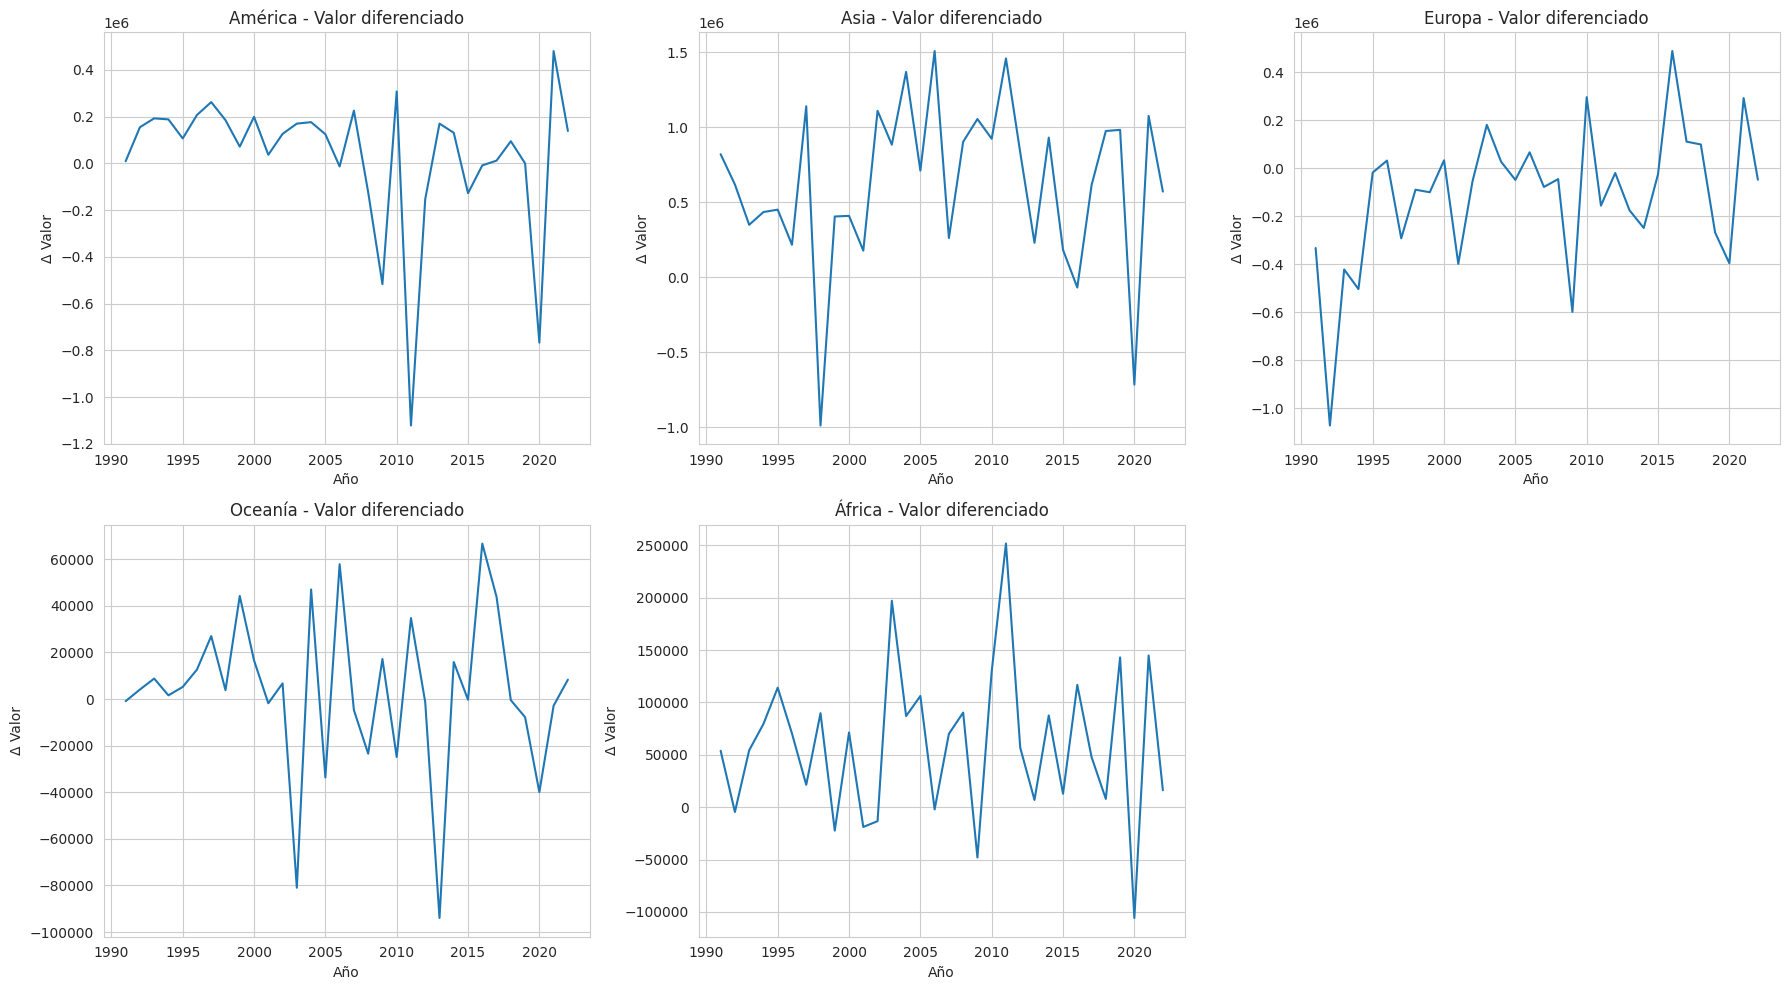

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

series_diff = [
    ('América', serie_america),
    ('Asia', serie_asia),
    ('Europa', serie_europa),
    ('Oceanía', serie_oceania),
    ('África', serie_africa),
]

for i, (nombre, df) in enumerate(series_diff):
  if 'Valor_diff' in df and df['Valor_diff'].dropna().size >= 3:
      sns.lineplot(x=df['Año'], y=df['Valor_diff'], ax=axes[i])
      axes[i].set_title(f'{nombre} - Valor diferenciado')
      axes[i].set_ylabel('Δ Valor')
  elif 'Valor' in df and df['Valor'].dropna().size >= 3:
      sns.lineplot(x=df.index, y=df['Valor'], ax=axes[i])
      axes[i].set_title(f'{nombre} - Serie original (estacionaria)')
      axes[i].set_ylabel('Valor')
  else:
      axes[i].set_title(f'{nombre} - Sin datos')
      axes[i].axis('off')

  axes[i].set_xlabel('Año')

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()



Al quitar la tendencia podemos observar las subidas y bajadas año a año.

--- América ---


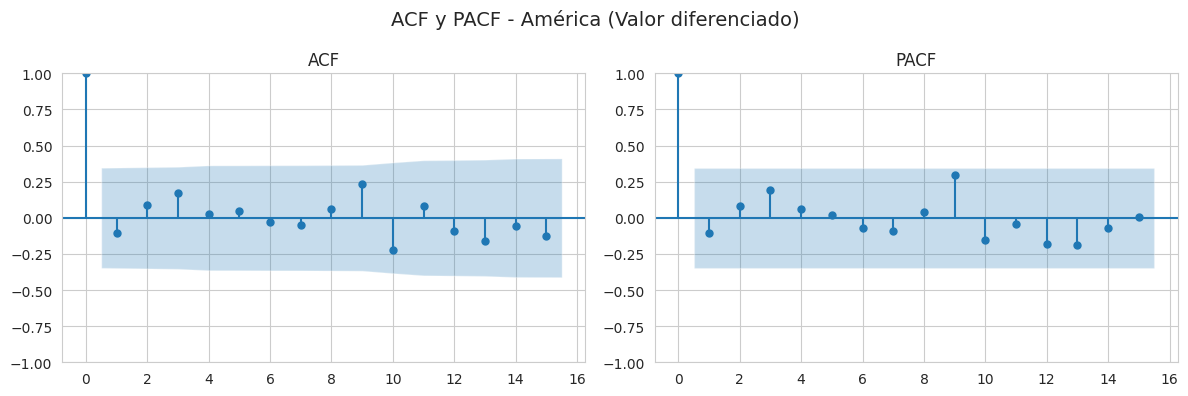

--- Asia ---


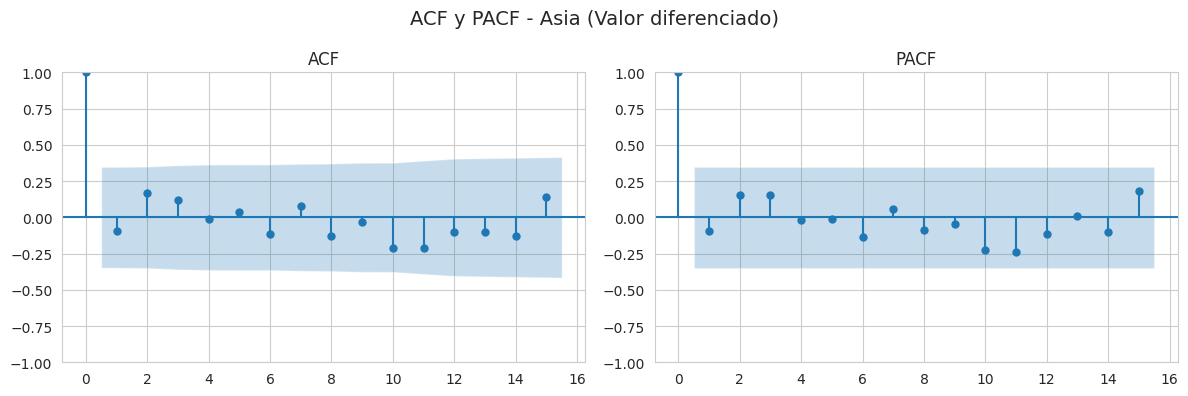

--- Europa ---


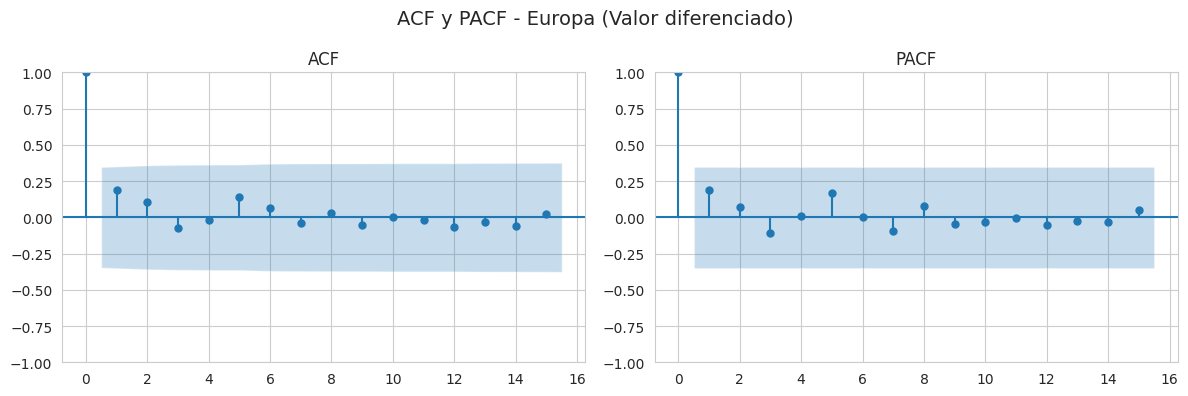

--- Oceanía ---


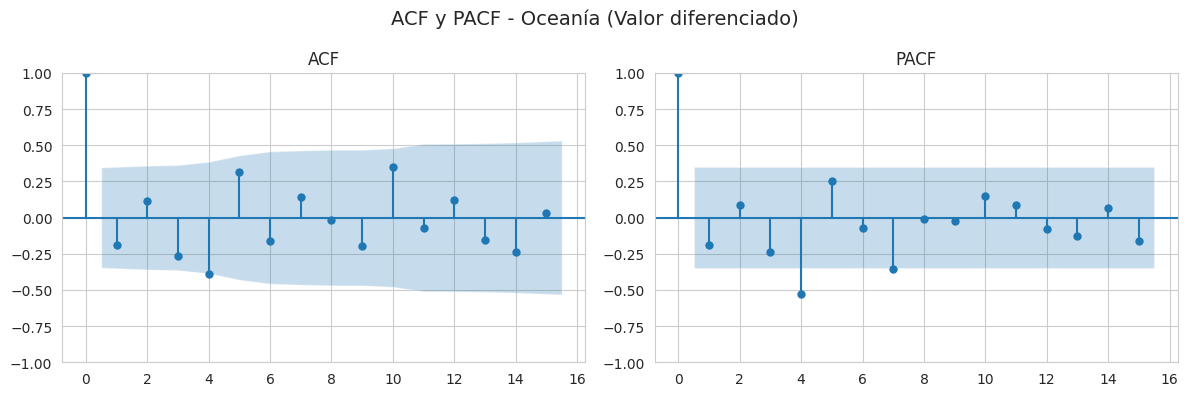

--- África ---


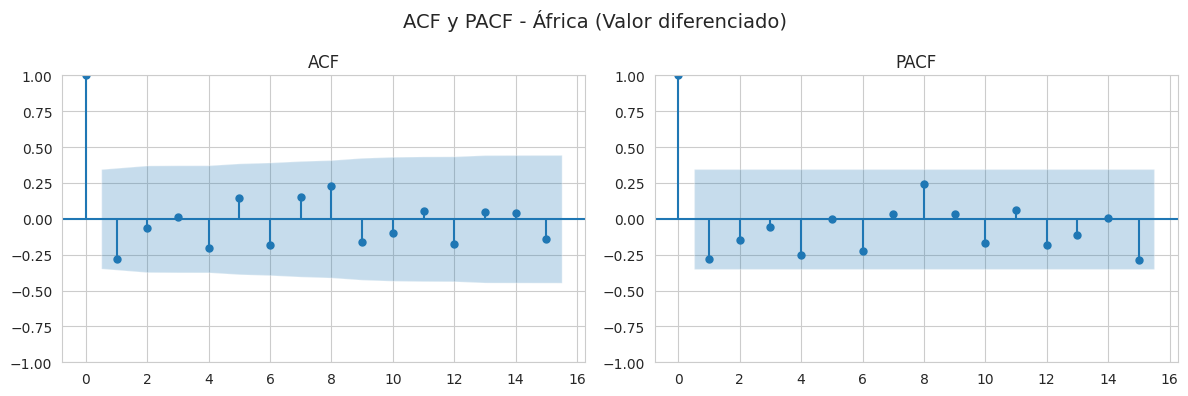

In [ ]:
for nombre, df in series_diff:
  print(f'--- {nombre} ---')

  if 'Valor_diff' not in df:
      print("No tiene columna 'Valor_diff', se omite.\n")
      continue

  serie = df['Valor_diff'].dropna()
  if len(serie) < 10:
      print("Muy pocos datos para mostrar ACF/PACF confiables\n")
      continue

  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(f'ACF y PACF - {nombre} (Valor diferenciado)', fontsize=14)

  plot_acf(serie, lags=15, ax=ax[0])
  plot_pacf(serie, lags=15, ax=ax[1])

  ax[0].set_title('ACF')
  ax[1].set_title('PACF')

  plt.tight_layout()
  plt.show()

La primera diferencia logró la estacionariedad: las colas largas de la ACF desaparecieron y la mayoría de las barras ahora están dentro de la franja de confianza. Todas las series cumplen el requisito de varianza y media constantes, por lo tanto ya podemos aplicar un modelo ARIMA.

Luego de lograr estacionariedad vamos a buscar el mejor modelo ARIMA para cada serie. El siguiente código permite comparar múltiples modelos con d=1 y p y 1 entre 0 y 3. Como resultado se presentan los 3 mejores modelos según precisión (MAPE), sencillez (AIC) y validez estadística (ruido blanco)

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")

series = {
    'América': serie_america['Valor'].astype(float),
    'Asia':    serie_asia['Valor'].astype(float),
    'Europa':  serie_europa['Valor'].astype(float),
    'Oceanía': serie_oceania['Valor'].astype(float),
    'África':  serie_africa['Valor'].astype(float)
}

h_test = 5
d      = 1

def grid_search_arima(y_train, y_test, p_max=3, q_max=3, top_k=3, lb_lags=10):
  '''
  Función que busca los mejores componentes AR-I-MA para cada continente
  '''
  resultados = []
  for p,q in itertools.product(range(p_max+1), range(q_max+1)):
    try:
        mod  = SARIMAX(y_train, order=(p,d,q),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

        #MAPE
        fc   = mod.get_forecast(steps=len(y_test)).predicted_mean
        mape = mean_absolute_percentage_error(y_test, fc)*100

        # Resiudos
        lb_p = acorr_ljungbox(mod.resid, lags=[lb_lags],
                              return_df=True)['lb_pvalue'].iloc[-1]

        resultados.append({
            'order': (p,d,q),
            'aic':   mod.aic,
            'mape':  mape,
            'lb_p':  lb_p,
            'ok':    lb_p > 0.05,
            'mod':   mod
        })
    except Exception:
          continue

  # orden: primero MAPE, segundo AIC
  resultados = sorted(resultados, key=lambda x: (x['mape'], x['aic']))
  return resultados[:top_k]

resultados = {}
for nombre, serie in series.items():
  print(f"\n----{nombre}----")
  y_train, y_test = serie.iloc[:-h_test], serie.iloc[-h_test:]
  top = grid_search_arima(y_train, y_test,
                          p_max=3, q_max=3, lb_lags=10)[:3]

  resultados[nombre] = top

  for i, cand in enumerate(top, 1):
      print(f"{i}. ARIMA{cand['order']}"
            f" | AIC={cand['aic']:.2f}"
            f" | MAPE test={cand['mape']:.2f}%"
            f" | Ljung‑Box p={cand['lb_p']:.3f} "
            f"({'OK' if cand['ok'] else 'NO'})")




----América----
1. ARIMA(3, 1, 3) | AIC=630.12 | MAPE test=1.93% | Ljung‑Box p=0.991 (OK)
2. ARIMA(0, 1, 3) | AIC=624.96 | MAPE test=1.94% | Ljung‑Box p=1.000 (OK)
3. ARIMA(1, 1, 3) | AIC=626.66 | MAPE test=1.94% | Ljung‑Box p=1.000 (OK)

----Asia----
1. ARIMA(1, 1, 1) | AIC=714.13 | MAPE test=3.88% | Ljung‑Box p=0.960 (OK)
2. ARIMA(2, 1, 0) | AIC=709.91 | MAPE test=4.26% | Ljung‑Box p=0.975 (OK)
3. ARIMA(1, 1, 0) | AIC=745.87 | MAPE test=4.27% | Ljung‑Box p=0.958 (OK)

----Europa----
1. ARIMA(3, 1, 2) | AIC=642.67 | MAPE test=3.72% | Ljung‑Box p=0.979 (OK)
2. ARIMA(1, 1, 3) | AIC=614.07 | MAPE test=3.88% | Ljung‑Box p=0.998 (OK)
3. ARIMA(3, 1, 3) | AIC=617.96 | MAPE test=3.92% | Ljung‑Box p=0.988 (OK)

----Oceanía----
1. ARIMA(2, 1, 3) | AIC=521.02 | MAPE test=0.91% | Ljung‑Box p=1.000 (OK)
2. ARIMA(1, 1, 3) | AIC=525.27 | MAPE test=1.27% | Ljung‑Box p=1.000 (OK)
3. ARIMA(0, 1, 3) | AIC=523.69 | MAPE test=1.29% | Ljung‑Box p=1.000 (OK)

----África----
1. ARIMA(2, 1, 3) | AIC=564.63 |

Se exploraron modelos ARIMA (p,1,q) con p y q entre 0 y 3. Para cada continente se muestran los 3 modelos con menor error de pronóstico sin sobreajustar la serie (AIC). Además, se evaluó que los residuales no presenten autocorrelación con el test Ljung-Box.

##### Modelos Seleccionados:
América: ARIMA(0,1,3)

Asia: ARIMA(1,1,1)

Europa: ARIMA(1, 1, 3)

Oceanía: ARIMA(2,1,3)

África: ARIMA(2,1,3)



=== América ===
                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                   27
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -308.480
Date:                Thu, 31 Jul 2025   AIC                            624.959
Time:                        20:38:07   BIC                            629.323
Sample:                             0   HQIC                           625.987
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0840      0.455     -0.185      0.853      -0.975       0.807
ma.L2          0.2277      0.228      1.000      0.317      -0.219       0.674
ma.L3          0.2232      0.375   

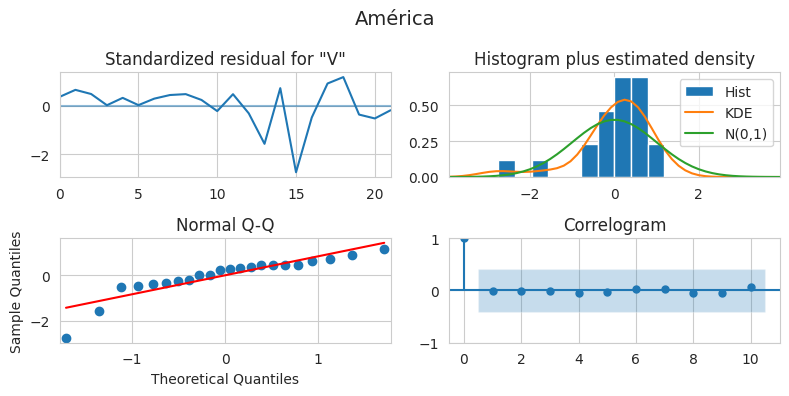


=== Asia ===
                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                   27
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -354.065
Date:                Thu, 31 Jul 2025   AIC                            714.130
Time:                        20:38:08   BIC                            717.665
Sample:                             0   HQIC                           715.068
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8330      0.094      8.818      0.000       0.648       1.018
ma.L1         -0.3901      0.139     -2.805      0.005      -0.663      -0.118
sigma2      3.273e+11      6e-14   5.4

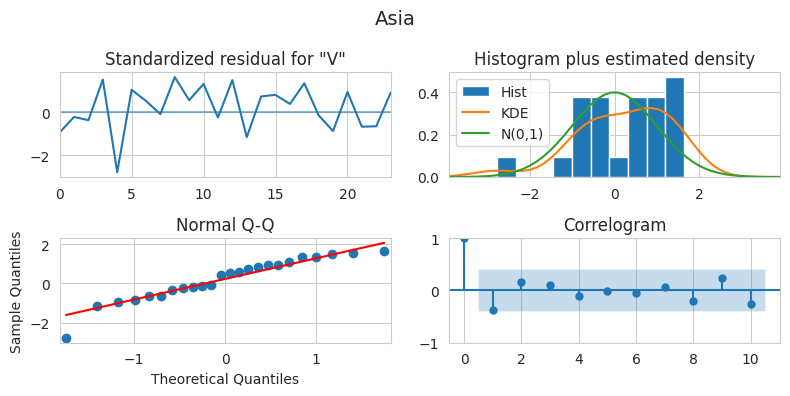


=== Europa ===
                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                   27
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -302.036
Date:                Thu, 31 Jul 2025   AIC                            614.071
Time:                        20:38:10   BIC                            619.527
Sample:                             0   HQIC                           615.357
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6071      0.434     -1.400      0.161      -1.457       0.243
ma.L1          0.6093      0.529      1.151      0.250      -0.428       1.647
ma.L2          0.0218      0.338    

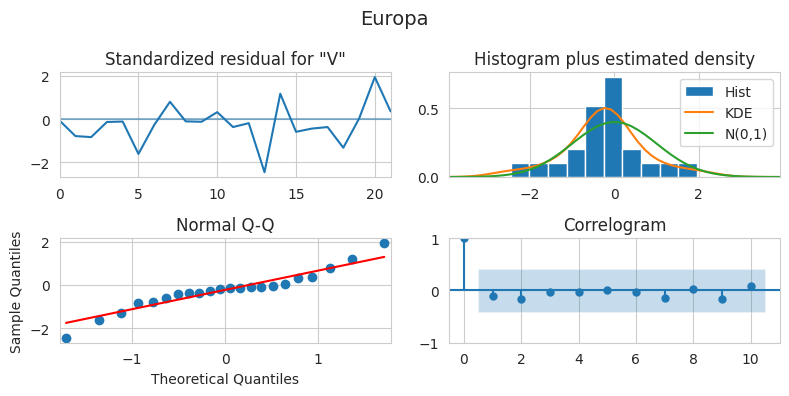


=== Oceanía ===
                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                   27
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -254.512
Date:                Thu, 31 Jul 2025   AIC                            521.024
Time:                        20:38:11   BIC                            527.570
Sample:                             0   HQIC                           522.566
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0626      0.075      0.839      0.401      -0.084       0.209
ar.L2          0.0882      0.100      0.885      0.376      -0.107       0.284
ma.L1         -0.2993      0.454   

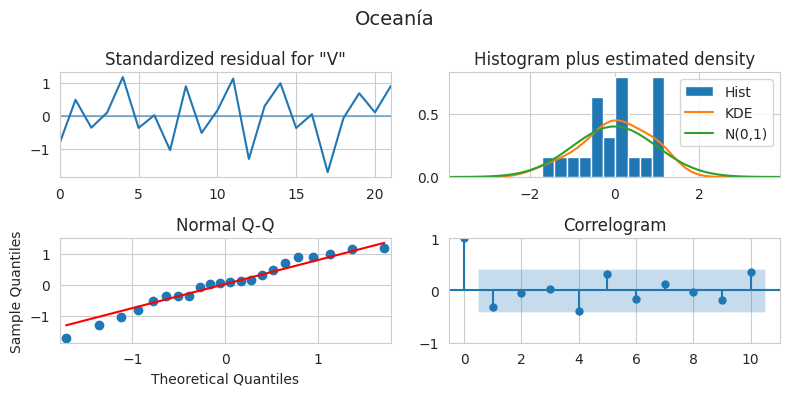


=== África ===
                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                   27
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -276.316
Date:                Thu, 31 Jul 2025   AIC                            564.632
Time:                        20:38:11   BIC                            571.178
Sample:                             0   HQIC                           566.174
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3973      0.182      2.183      0.029       0.041       0.754
ar.L2          0.5146      0.187      2.754      0.006       0.148       0.881
ma.L1          0.4875      0.586    

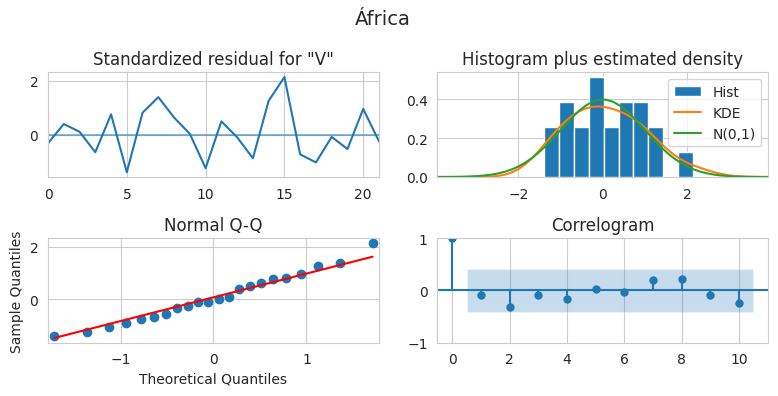

In [ ]:
parametros_arima = {
    'América': (0, 1, 3),
    'Asia': (1, 1, 1),
    'Europa': (1, 1, 3),
    'Oceanía': (2, 1, 3),
    'África': (2, 1, 3)
}

series_dict = {
    'América': serie_america,
    'Asia': serie_asia,
    'Europa': serie_europa,
    'Oceanía': serie_oceania,
    'África': serie_africa
}

h_test = 5

for nombre, df in series_dict.items():
  print(f'\n=== {nombre} ===')
  y = df['Valor'].dropna()
  y_train, y_test = y.iloc[:-h_test], y.iloc[-h_test:]
  if len(y_train) < 10:
      print("Muy pocos datos para ajustar el modelo.\n")
      continue

  try:
      p, d, q = parametros_arima[nombre]
      model = SARIMAX(
              y_train,
              order=(p, d, q),
              enforce_stationarity=False,
              enforce_invertibility=False
          )
      res = model.fit(disp=False)
      print(res.summary())

      res.plot_diagnostics(figsize=(8, 4))
      plt.suptitle(f'{nombre}', fontsize=14)
      plt.tight_layout()
      plt.show()

  except Exception as e:
      print(f"Error al ajustar modelo para {nombre}: {e}\n")


Podemos observar que en los gráficos de Línea de residuales, los errores del modelo año a año oscilan alrededor de cero, salvo algún pico aislado en América.

En el histograma podemos ver la distribución de los errores. Tanto en África como en Asia la distribución coincide bastante con la línea verde (distr normal), mientras en América y Europa hay colas un poco mas anchas. Oceanía es el mejor ajuste de todos.

En el Q-Q plot se comparan los errores reales con los que tendría una campana normal perfecta. Podemos ver que casi todos los puntos acompañana a la línea roja, salvo leves desvíos.

Por último, el correlograma de residuales nos permite observar si hay memoria en los errores. En los gráficos se ve que las barras estan dentro de ka franja azul.

##Predicciones

En el caso de África y Asia, luego de la primera diferenciación observamos que los cambios anuales son casi siempre positivos, es decir cada año se emite un poco más. Es por esto que añadimos "trend = t" al modelo, para que el modelo proyecte hacia arriba teniendo en cuenta los datos recientes. Otra opción podría ser hacer una segunda diferenciación pero podríamos tener más ruido.

América: MAPE test = 1.94%


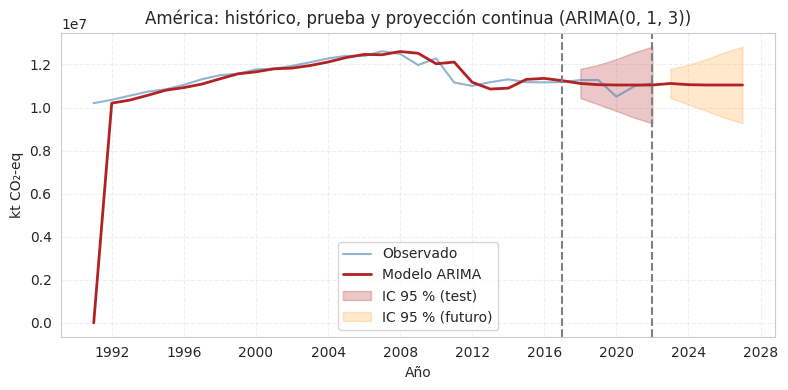

Asia: MAPE test = 2.87%


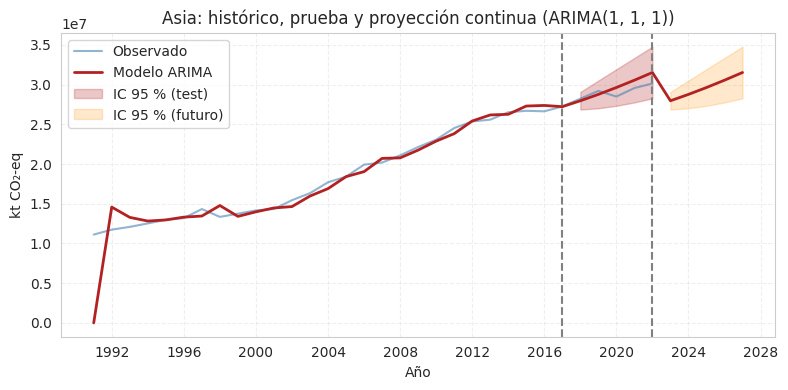

Europa: MAPE test = 3.88%


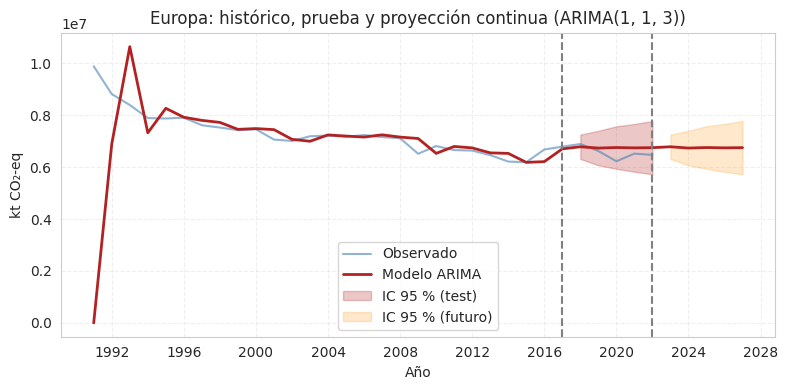

Oceanía: MAPE test = 0.91%


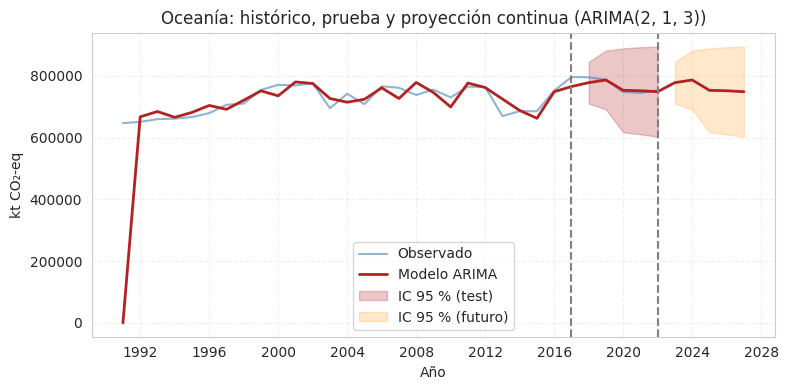

África: MAPE test = 3.48%


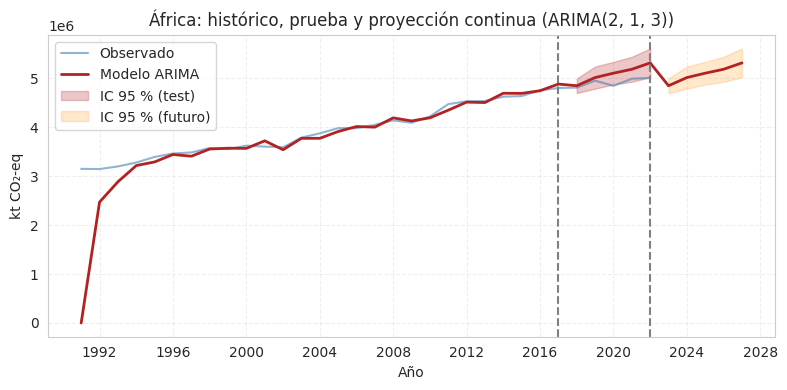

In [ ]:
modelos_config = {
    'América':  {'order': (0, 1, 3)},
    'Asia':     {'order': (1, 1, 1), 'trend': 't'},
    'Europa':   {'order': (1, 1, 3)},
    'Oceanía':  {'order': (2, 1, 3)},
    'África':   {'order': (2, 1, 3), 'trend': 't'}
}

h_test, h_future = 5, 5

for nombre, df in series_dict.items():
  # Serie
  serie = (df.set_index('Año')['Valor']
              .sort_index()
              .dropna()
              .astype(float))
  serie.index = pd.PeriodIndex(serie.index, freq='Y')

  y_train, y_test = serie.iloc[:-h_test], serie.iloc[-h_test:]

  # Modelo
  cfg   = modelos_config[nombre]
  trend = cfg.get('trend', 'n')

  res = SARIMAX(y_train,
                order=cfg['order'],
                trend=trend,
                enforce_stationarity=False,
                enforce_invertibility=False).fit(disp=False)

  fitted = res.fittedvalues                               # 1990-2017

  fc_test   = res.get_forecast(h_test)                    # 2018-2022
  pred_test = fc_test.predicted_mean
  ci_test   = fc_test.conf_int()

  fc_fut    = res.get_forecast(h_future)                  # 2023-2027
  pred_fut  = fc_fut.predicted_mean
  ci_fut    = fc_fut.conf_int()

  pred_test.index = pd.period_range(y_train.index[-1]+1,
                                    periods=h_test, freq='Y')
  pred_fut.index  = pd.period_range(pred_test.index[-1]+1,
                                    periods=h_future, freq='Y')
  ci_test.index, ci_fut.index = pred_test.index, pred_fut.index


  pred_full = pd.concat([fitted, pred_test, pred_fut])

  # MAPE
  mape = mean_absolute_percentage_error(y_test, pred_test)*100
  print(f"{nombre}: MAPE test = {mape:.2f}%")

  fig, ax = plt.subplots(figsize=(8,4))
  ax.plot(serie.index.to_timestamp(), serie, label='Observado', color='steelblue', alpha=.6)
  ax.plot(pred_full.index.to_timestamp(), pred_full, color='firebrick', lw=2,
          label='Modelo ARIMA')
  ax.fill_between(pred_test.index.to_timestamp(), ci_test.iloc[:,0], ci_test.iloc[:,1],
                  color='firebrick', alpha=.25, label='IC 95 % (test)')
  ax.fill_between(pred_fut.index.to_timestamp(), ci_fut.iloc[:,0], ci_fut.iloc[:,1],
                  color='darkorange', alpha=.20, label='IC 95 % (futuro)')

  ax.axvline(y_train.index[-1].to_timestamp(), color='grey', ls='--')
  ax.axvline(y_test.index[-1].to_timestamp(),  color='grey', ls='--')

  ax.set(title=f'{nombre}: histórico, prueba y proyección continua (ARIMA{cfg["order"]})',
          xlabel='Año', ylabel='kt CO₂-eq')
  ax.legend(); ax.grid(ls='--', alpha=.3)
  plt.tight_layout()
  plt.show()

### Caso Oceanía

En la serie de Oceanía habíamos observado que la varianza explicada por un ciclo de 5 años es mayor al 38%. Pero, luego de diferenciar, observamos los gráficos ACF y PACF y los lags 4,5 y 10 caen dentro de la franja azul, por lo que la estacionalidad ya está explicada. Además, aplicar SARIMA implica agregar mas parámetros para sólo 6 ciclos observados (30 años), al ser pocos datos se podría provocar un sobreajuste. Además, los resultados de ARIMA nos dicen que el modelo ajusta bien.